USD MS AAI - 510 Machine Learning - Final Project:

### EEG data human emotion classifier


Use EEG brain-machine interface data collected by Neurosky MindSet headband
<br>as input to predict human emotion (confusion)



Group 5: Dheemanth Rajakumar, Puja Nandini and Darin Verduzco

GitHub: https://github.com/caliskate/neuro-emotion-classifier

Dataset source: https://www.kaggle.com/datasets/wanghaohan/confused-eeg/data?select=EEG_data.csv



Models used for performance comparison:

<br>XGBoost
<br>RandomForest
<br>SVM
<br>MLP
<br>LogisticRegression
<br>LSTM

# Import Libraries

In [1]:
# Standard Library Imports
import os
import pickle
import time
import warnings
from collections import Counter

# Configuration and Reproducibility
warnings.filterwarnings('ignore')  # Suppress warnings
np.random.seed(42)  # Set random seed for reproducibility
PYTHONHASHSEED = 0  # Set Python hash seed for reproducibility

# Data Handling and Analysis
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import f_oneway

# Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')  # Revert to Matplotlib's default style
%matplotlib inline  # if using Jupyter

# Machine Learning - Preprocessing
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    label_binarize
)
from sklearn.decomposition import PCA

# Machine Learning - Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    f1_score
)

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# Imbalanced Data Techniques
from imblearn.over_sampling import SMOTE

# Deep Learning - Keras / TensorFlow
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

from tensorflow.keras.models import Sequential as TFSequential  # optional alias
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import Adam

# Model Explainability
import shap

# Load and evaluate data

describe / info 

check for missing or duplicate values - none

check datatypes - allfloat64

check target value counts - roughly even

description of each column type

check avg sampling rate

check data per videoID

In [2]:
raw_df = pd.read_csv('EEG_data_confused.csv')
raw_df.head()

SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  \
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0   
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0   
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0   
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0   
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0   

   user-definedlabeln  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [3]:
raw_df['SubjectID'].value_counts()

SubjectID
3.0    1314
1.0    1301
4.0    1295
2.0    1284
8.0    1282
7.0    1276
6.0    1275
5.0    1262
0.0    1261
9.0    1261
Name: count, dtype: int64

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


In [5]:
raw_df.describe()

SubjectID       VideoID     Attention     Mediation           Raw  \
count  12811.000000  12811.000000  12811.000000  12811.000000  12811.000000   
mean       4.487394      4.390602     41.313871     47.182656     65.570760   
std        2.865373      2.913232     23.152953     22.655976    597.921035   
min        0.000000      0.000000      0.000000      0.000000  -2048.000000   
25%        2.000000      2.000000     27.000000     37.000000    -14.000000   
50%        4.000000      4.000000     43.000000     51.000000     35.000000   
75%        7.000000      7.000000     57.000000     63.000000     90.000000   
max        9.000000      9.000000    100.000000    100.000000   2047.000000   

              Delta         Theta        Alpha1        Alpha2         Beta1  \
count  1.281100e+04  1.281100e+04  1.281100e+04  1.281100e+04  1.281100e+04   
mean   6.057853e+05  1.680526e+05  4.138435e+04  3.318339e+04  2.431837e+04   
std    6.376236e+05  2.441346e+05  7.243082e+04  5.831410e+04  3.837968e+04   
min    4.480000e+02  1.700000e+01  2.000000e+00  2.000000e+00  3.000000e+00   
25%    9.806400e+04  2.691750e+04  6.838000e+03  6.852000e+03  6.140000e+03   
50%    3.954870e+05  8.133100e+04  1.750000e+04  1.495900e+04  1.281800e+04   
75%    9.166230e+05  2.052760e+05  4.477950e+04  3.455050e+04  2.740600e+04   
max    3.964663e+06  3.007802e+06  1.369955e+06  1.016913e+06  1.067778e+06   

              Beta2        Gamma1        Gamma2  predefinedlabel  \
count  1.281100e+04  1.281100e+04  1.281100e+04     12811.000000   
mean   3.814433e+04  2.959255e+04  1.441597e+04         0.479978   
std    7.906606e+04  7.982637e+04  3.603523e+04         0.499618   
min    2.000000e+00  1.000000e+00  2.000000e+00         0.000000   
25%    7.358500e+03  4.058000e+03  2.167500e+03         0.000000   
50%    1.581000e+04  9.763000e+03  5.116000e+03         0.000000   
75%    3.549400e+04  2.488800e+04  1.266950e+04         1.000000   
max    1.645369e+06  1.972506e+06  1.348117e+06         1.000000   

       user-definedlabeln  
count        12811.000000  
mean             0.512606  
std              0.499861  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  
max              1.000000

In [6]:
raw_df.head()

SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  \
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0   
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0   
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0   
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0   
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0   

   user-definedlabeln  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [7]:
# Rows, columns
raw_df.shape 

(12811, 15)

In [8]:
# Show col datatypes in df
raw_df.dtypes

SubjectID             float64
VideoID               float64
Attention             float64
Mediation             float64
Raw                   float64
Delta                 float64
Theta                 float64
Alpha1                float64
Alpha2                float64
Beta1                 float64
Beta2                 float64
Gamma1                float64
Gamma2                float64
predefinedlabel       float64
user-definedlabeln    float64
dtype: object

In [9]:
# Total missing values in df
raw_df.isnull().sum().sum()

0

In [10]:
# Count duplicate rows
raw_df.duplicated().sum()

0

In [11]:
# Count target labels
raw_df['user-definedlabeln'].value_counts()

user-definedlabeln
1.0    6567
0.0    6244
Name: count, dtype: int64

In [12]:
# Count SubjectID
raw_df['SubjectID'].nunique()

10

 NeuroSky MindSet (and related headsets like the MindWave/MindWave Mobile) sample raw EEG at 512 Hz,
 using a 12-bit resolution ADC, 
 
 and capture brainwave data in the 3–100 Hz range 
<br>store.neurosky.com


In [13]:
print("Min Raw value:", raw_df['Raw'].min())
print("Max Raw value", raw_df['Raw'].max())

Min Raw value: -2048.0
Max Raw value 2047.0


NeuroSky uses a 12-bit ADC, a 12-bit signed integer gives a range of:

-2^11 to 2^11 (-2048 to +2047)
<br>Conclusion: Raw units sugest raw ADC counts, not calibrated voltages.
<br>They represent total brain activity over time, unfiltered.

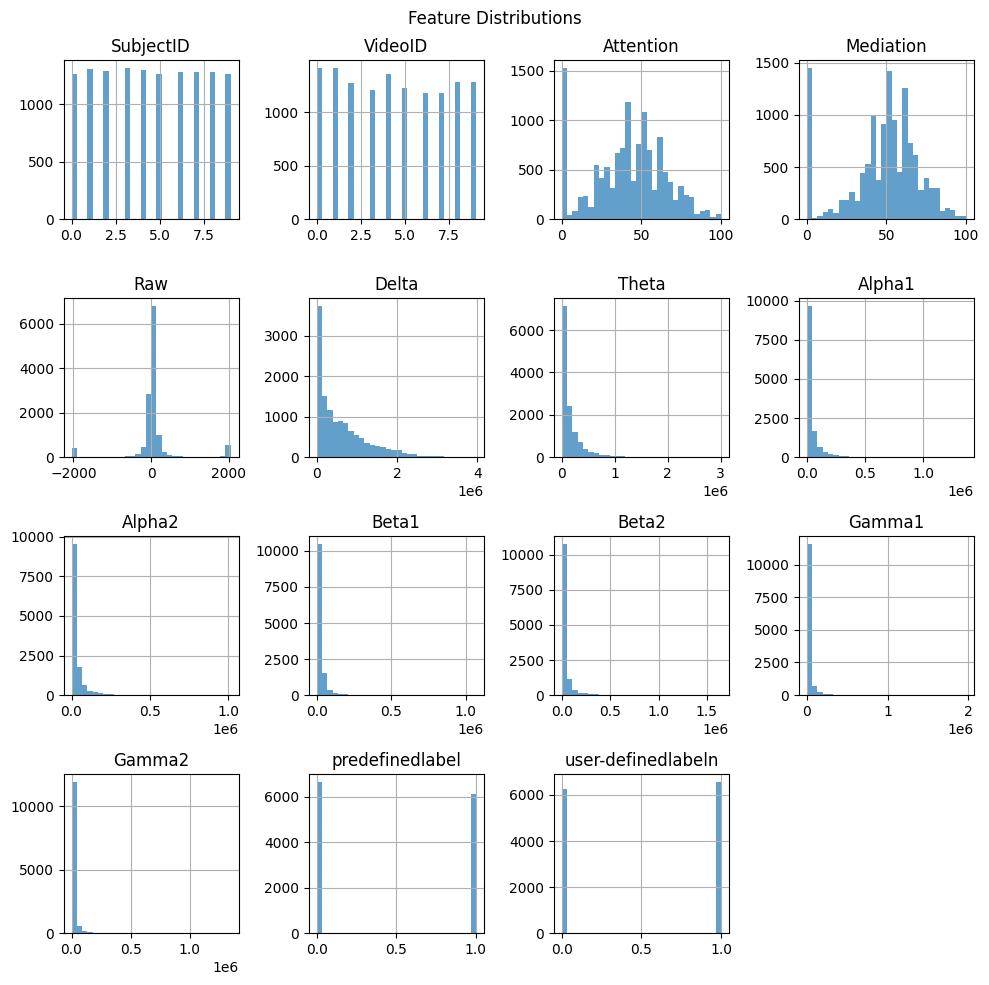

In [14]:
# Class distribution visualization
raw_df.hist(bins=30, alpha=0.7, figsize=(10, 10))
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

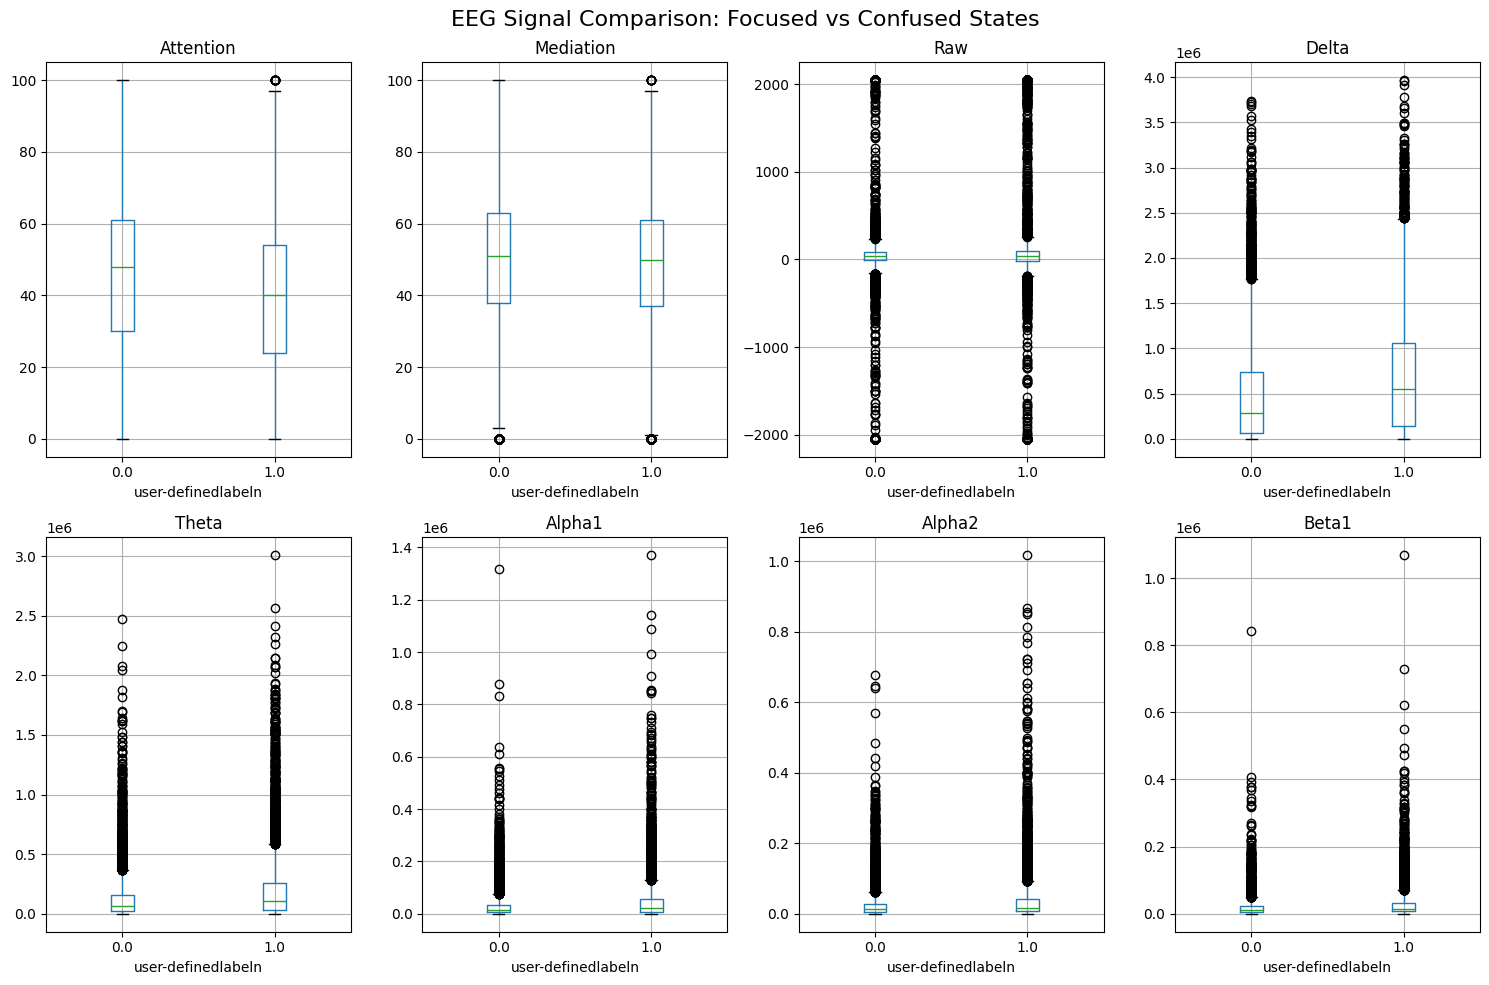


Outliers detected in EEG data: 4430 rows (34.58%)


In [15]:
# Identify EEG feature columns (exclude target and ID columns)
eeg_columns = [col for col in raw_df.columns if col not in ['SubjectID', 'VideoID', 'predefinedlabel']]

# Compare EEG signals between cognitive states
plt.figure(figsize=(15, 10))

# Box plots for EEG channels
for i, channel in enumerate(eeg_columns[:8]):
    plt.subplot(2, 4, i+1)
    raw_df.boxplot(column=channel, by='user-definedlabeln', ax=plt.gca())
    plt.title(f'{channel}')
    plt.suptitle('')  # Remove default title inside loop

plt.suptitle('EEG Signal Comparison: Focused vs Confused States', fontsize=16)
plt.tight_layout()
plt.show()

# Outlier detection using IQR method
def detect_outliers_iqr(data, columns):
    outlier_indices = set()
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index
        outlier_indices.update(outliers)
    return list(outlier_indices)

outlier_indices = detect_outliers_iqr(raw_df, eeg_columns)
print(f"\nOutliers detected in EEG data: {len(outlier_indices)} rows ({len(outlier_indices)/len(raw_df)*100:.2f}%)")

# Add units of time

 From the dataset decription, there were 20 videos, 10 simple ones and 10 complex ones, each 2 minutes long. 

 We will estimate sampling rate of equipment based on length of VideoID and number of datapoints per videoID.

In [16]:
# Count samples per VideoID
sample_counts = raw_df.groupby('VideoID').size()

# Assume each video is 2 minutes = 120 seconds
video_duration_sec = 120

# Calculate estimated sampling rate for each video
sampling_rates = sample_counts / video_duration_sec

# Print average sampling rate across all videos
avg_sampling_rate = sampling_rates.mean()
print(f"\nAverage estimated sampling rate: {avg_sampling_rate:.2f} Hz")


Average estimated sampling rate: 10.68 Hz


In [17]:
# Use estimated sampliung rate to estimate seconds_elapsed, confirm ~120 sec per VideoID

# Copy raw df
time_df = raw_df.copy()

# Create a group-wise sample count (starting at 0 for each VideoID)
time_df['sample_in_video'] = time_df.groupby('VideoID').cumcount()

# Calculate seconds elapsed within each VideoID group
time_df['seconds_elapsed'] = time_df['sample_in_video'] / avg_sampling_rate

# Print max seconds_elapsed for each VideoID
max_times = time_df.groupby('VideoID')['seconds_elapsed'].max()
print(max_times)

VideoID
0.0    132.167668
1.0    132.355007
2.0    119.241277
3.0    112.871751
4.0    126.922176
5.0    115.119819
6.0    110.530013
7.0    110.155335
8.0    119.803294
9.0    119.896964
Name: seconds_elapsed, dtype: float64


# Visualize slice of Alpha1 vs time vs label

showing 3 groups of PSD data for when the label is negative, positive and neutral

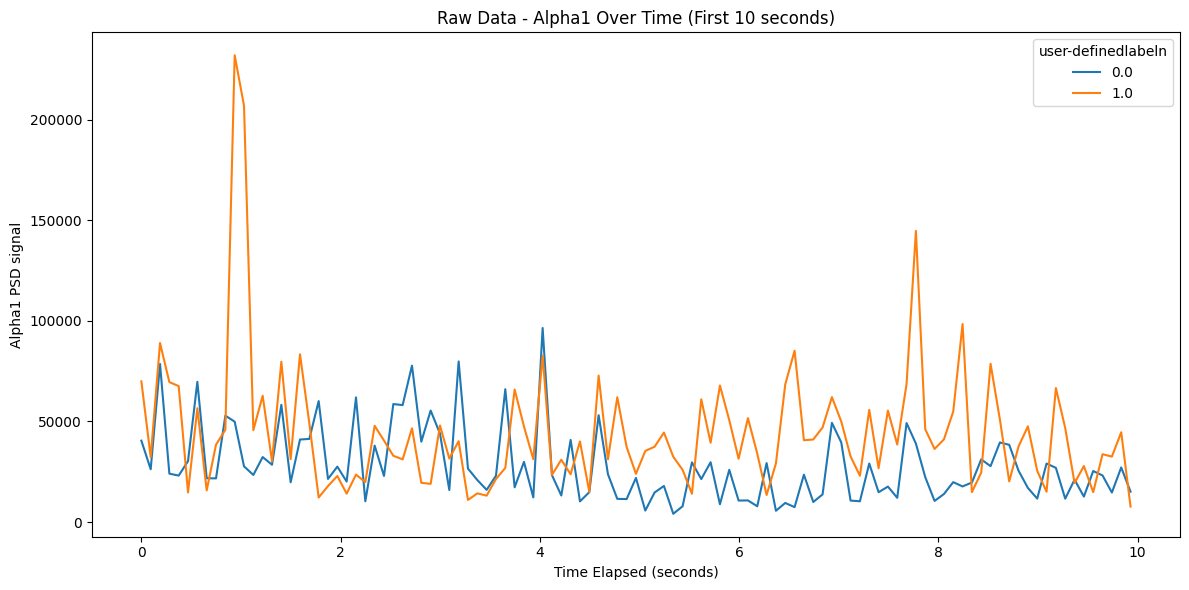

In [18]:
# Select a reasonable slice of time, e.g., first 10 seconds
slice_df = time_df[time_df['seconds_elapsed'] <= 10]

# Plot time vs alpha1, color-coded by label
plt.figure(figsize=(12, 6))
sns.lineplot(data=slice_df, x='seconds_elapsed', y='Alpha1', hue='user-definedlabeln', errorbar=None)
plt.title('Raw Data - Alpha1 Over Time (First 10 seconds)')
plt.xlabel('Time Elapsed (seconds)')
plt.ylabel('Alpha1 PSD signal')
plt.legend(title='user-definedlabeln')
plt.tight_layout()
# Remove sci notation from y axis
plt.ticklabel_format(style='plain', axis='y')
plt.show()

goal of interpretation: look for different levels of ALpha1 for different target labels

confused label is when alpha1 is generally more elevated here
<br>non confused label is when alpha1 is lower in values aside from peak at 8 second mark

# Denoising brainwave columns with values binned by 0.5 seconds
# (bin_avg_df)
Plot binned avg brainwave band PSD values

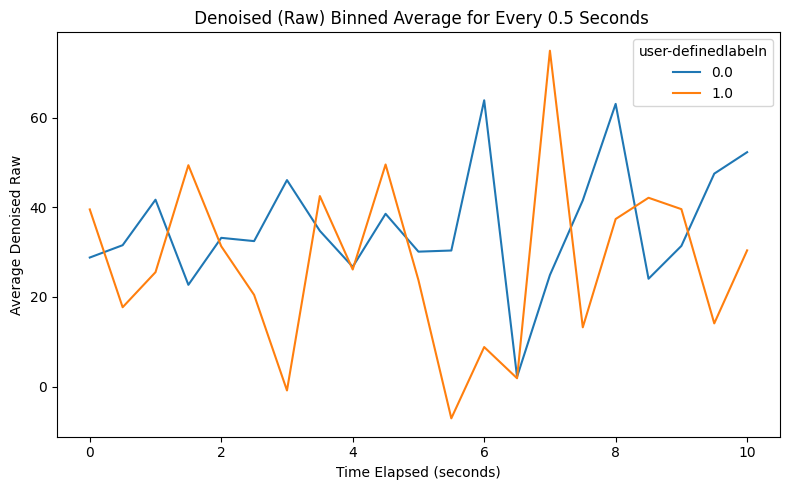

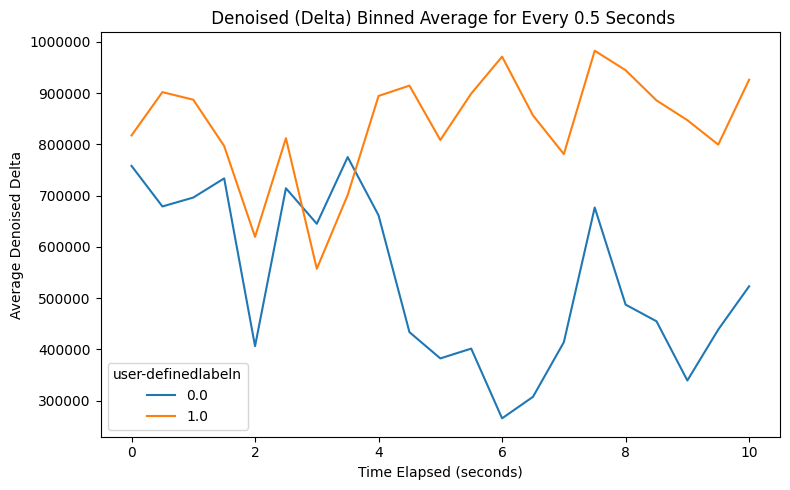

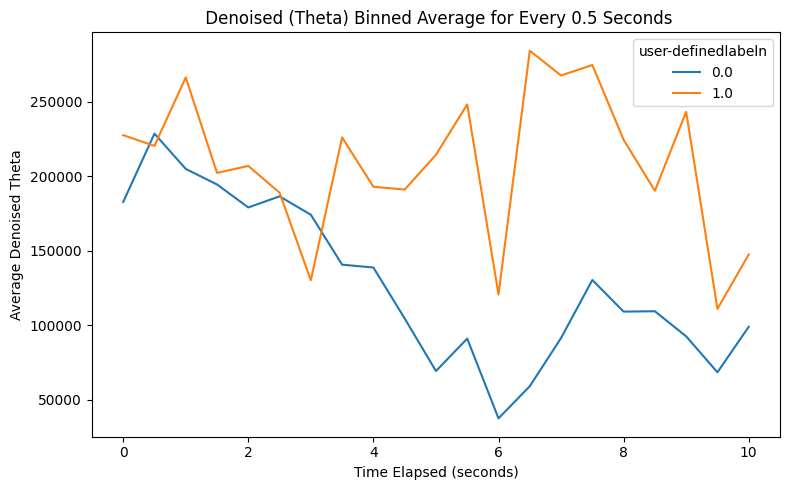

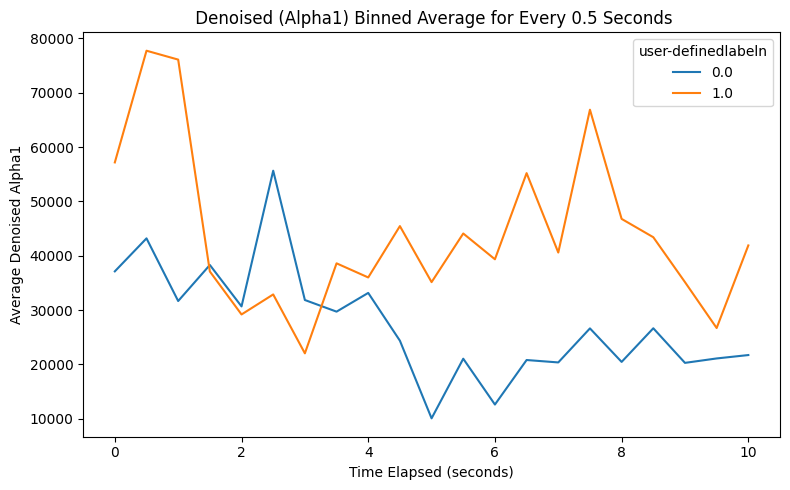

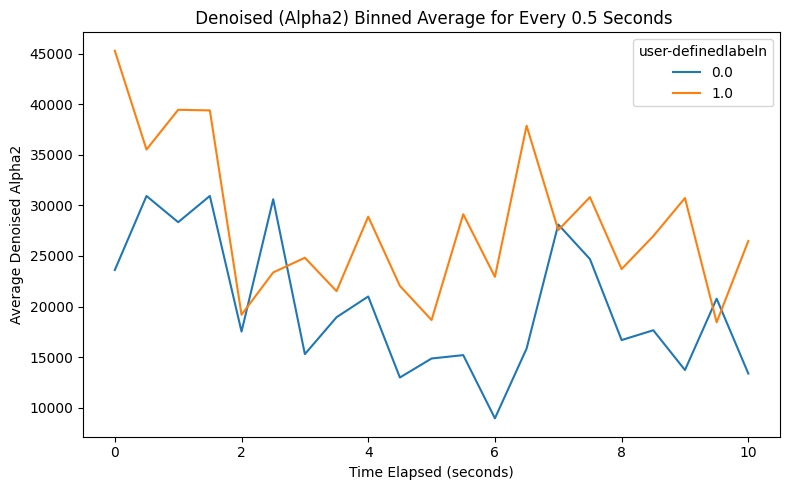

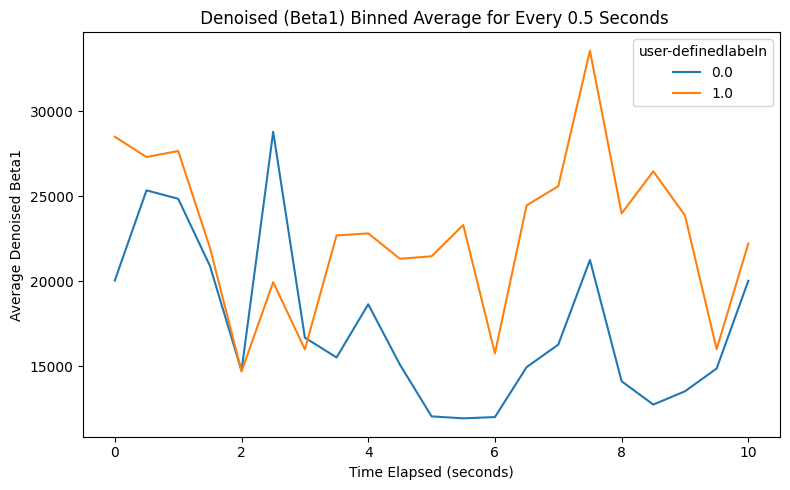

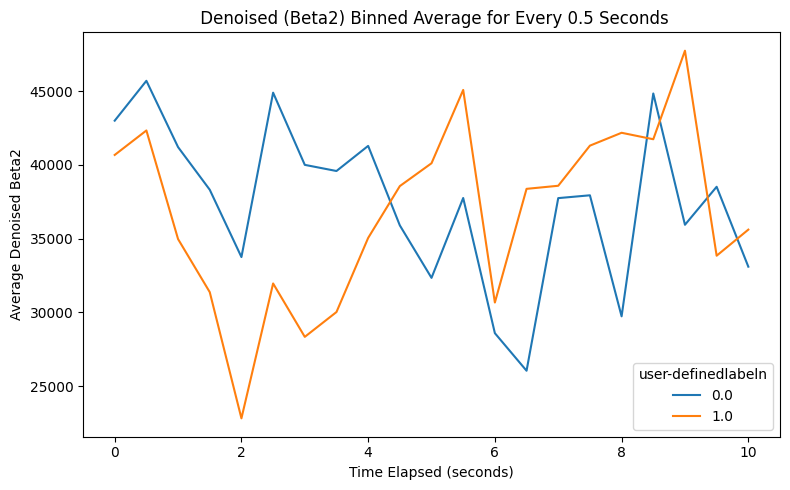

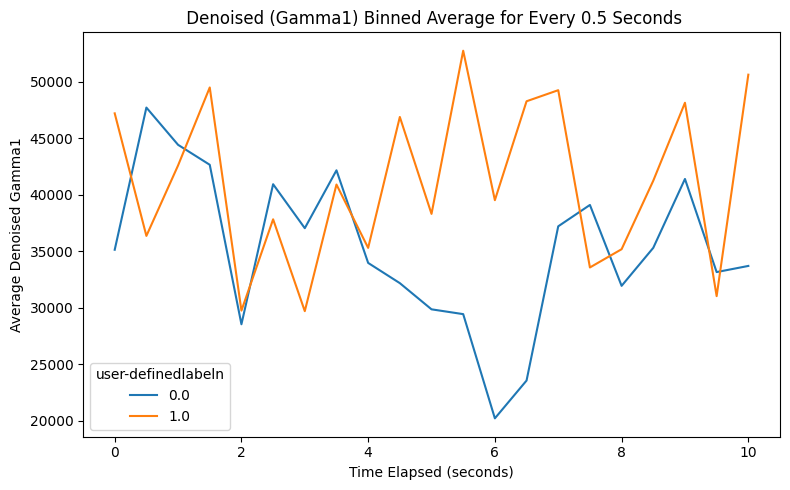

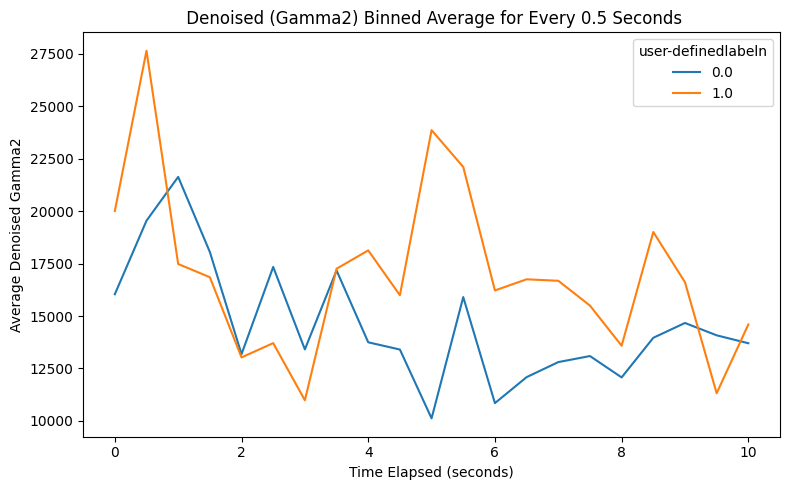

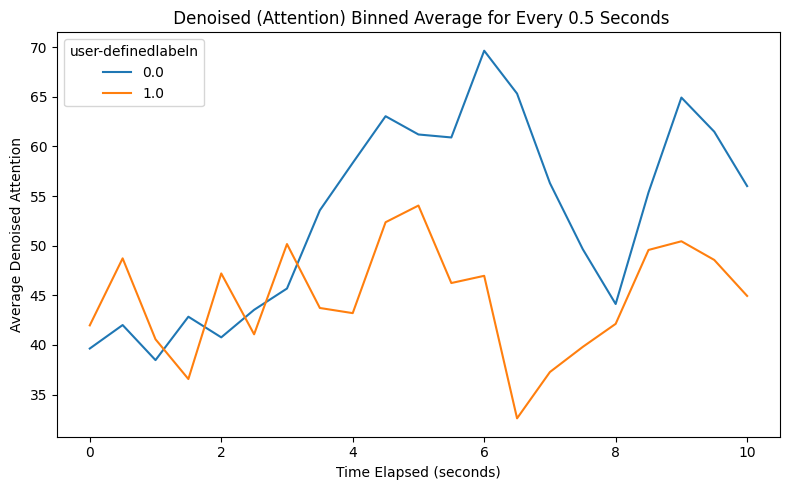

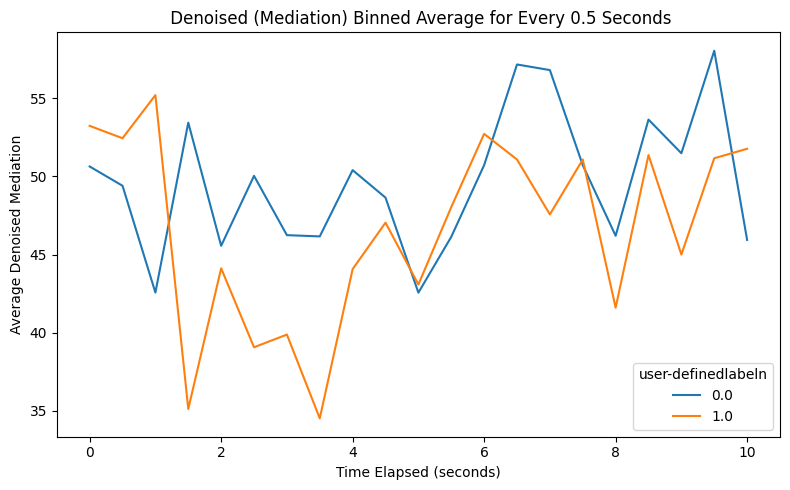

In [19]:
# Create a copy to hold binned data
bin_df = time_df.copy()
# Bin size in seconds
seconds_in_bin = 0.5
# Create time bins
bin_df['time_bin'] = (bin_df['seconds_elapsed'] // seconds_in_bin) * seconds_in_bin

# Define brainwave columns
brainwave_cols = ['Raw','Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2','Attention','Mediation']

# Group by time_bin and label, average all brainwave columns
bin_avg_df = bin_df.groupby(['time_bin', 'user-definedlabeln'], as_index=False)[brainwave_cols].mean()

# Slice for plotting (first 10 seconds only)
slice_df = bin_avg_df[bin_avg_df['time_bin'] <= 10]

# Plot each brainwave denoised
for col in brainwave_cols:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=slice_df, x='time_bin', y=col, hue='user-definedlabeln')
    plt.title(f' Denoised ({col}) Binned Average for Every {seconds_in_bin} Seconds')
    plt.xlabel('Time Elapsed (seconds)')
    plt.ylabel(f'Average Denoised {col}')
    plt.legend(title='user-definedlabeln')
    # Remove sci notation from y axis
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()

In [20]:
bin_avg_df.head()

time_bin  user-definedlabeln        Raw          Delta          Theta  \
0       0.0                 0.0  28.766667  757999.400000  182793.466667   
1       0.0                 1.0  39.500000  817392.233333  227675.700000   
2       0.5                 0.0  31.520000  678793.960000  228688.760000   
3       0.5                 1.0  17.680000  901936.600000  220486.680000   
4       1.0                 0.0  41.666667  696201.133333  205018.033333   

         Alpha1        Alpha2         Beta1         Beta2        Gamma1  \
0  37136.333333  23608.833333  20052.100000  42993.266667  35134.133333   
1  57189.200000  45275.200000  28508.966667  40671.100000  47203.266667   
2  43208.680000  30923.280000  25355.000000  45694.280000  47714.800000   
3  77749.960000  35511.440000  27313.800000  42328.640000  36360.680000   
4  31676.766667  28332.433333  24859.366667  41201.600000  44419.366667   

         Gamma2  Attention  Mediation  
0  16040.033333  39.633333  50.633333  
1  20013.633333  41.966667  53.233333  
2  19549.520000  42.000000  49.400000  
3  27656.480000  48.720000  52.440000  
4  21637.200000  38.466667  42.566667

Brainwave values generally higher when confused except for Attention

# Denoising with rolling average for LSTM (model 4)
# (roll_avg_df)

In [21]:
time_df.head()

SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  \
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0   
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0   
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0   
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0   
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0   

   user-definedlabeln  sample_in_video  seconds_elapsed  
0                 0.0                0         0.000000  
1                 0.0                1         0.093670  
2                 0.0                2         0.187339  
3                 0.0                3         0.281009  
4                 0.0                4         0.374678

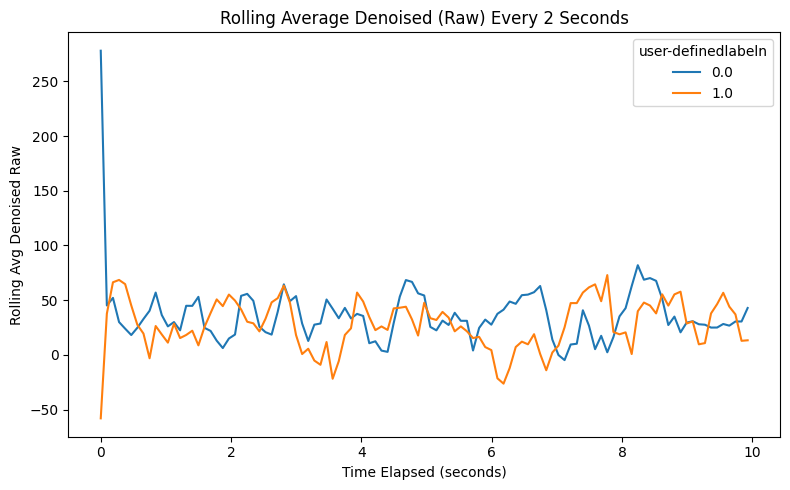

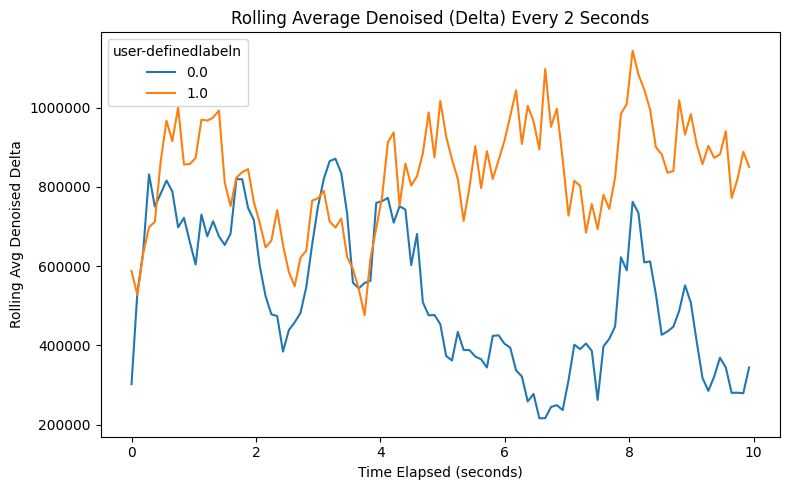

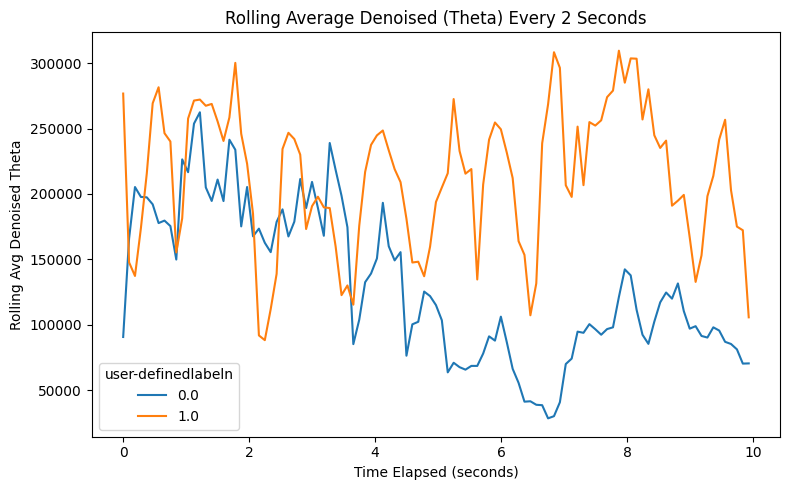

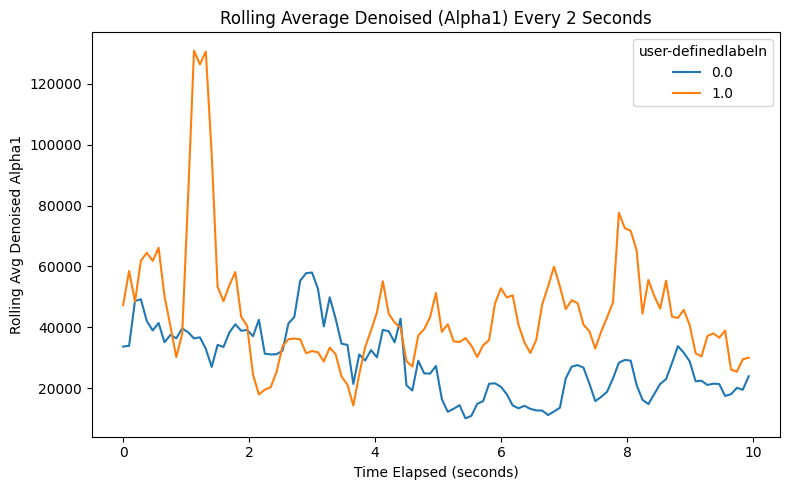

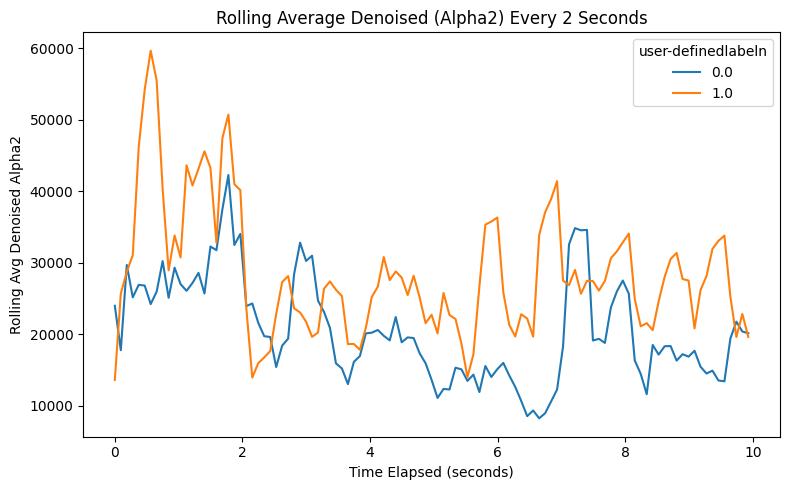

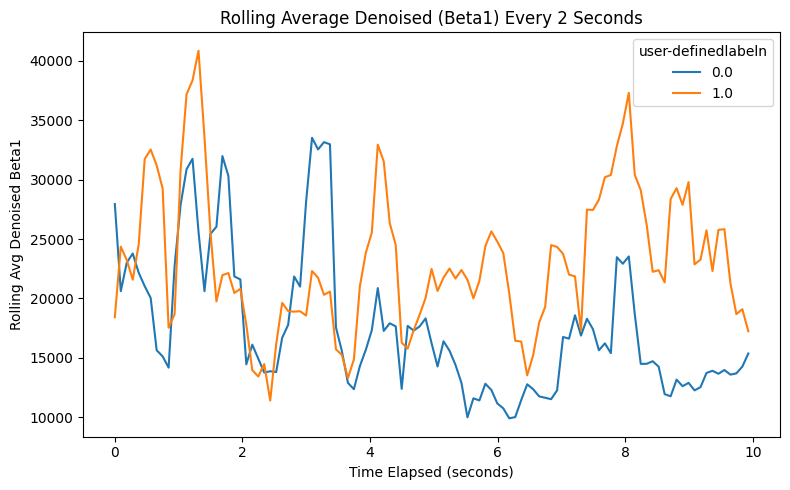

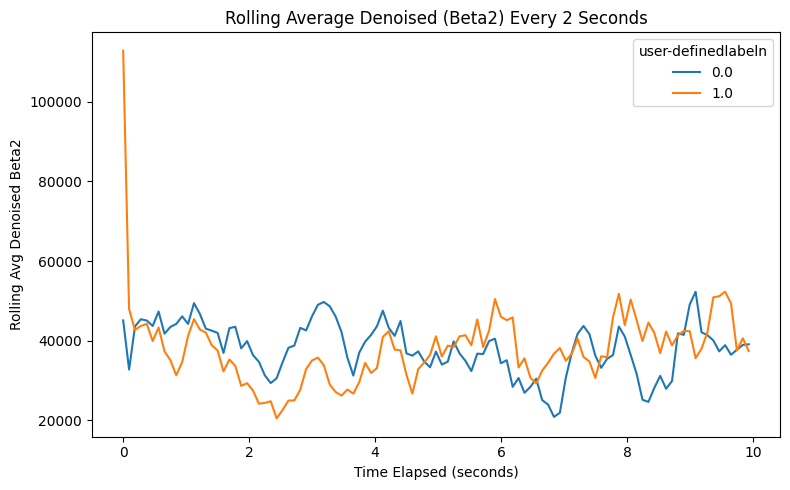

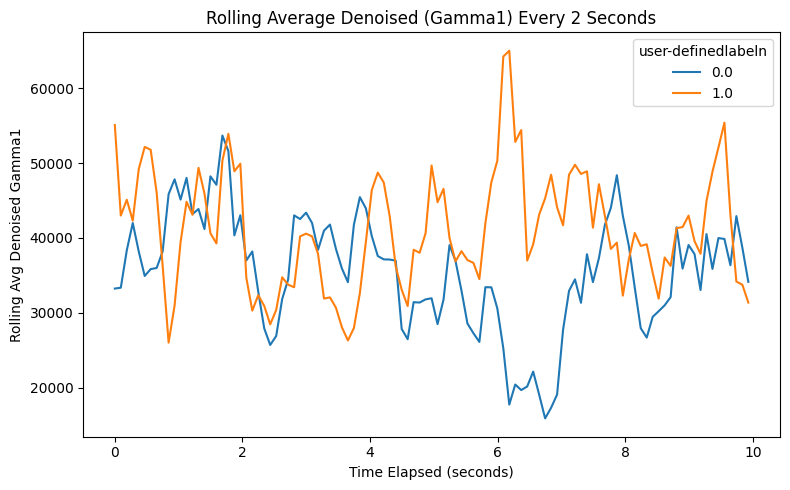

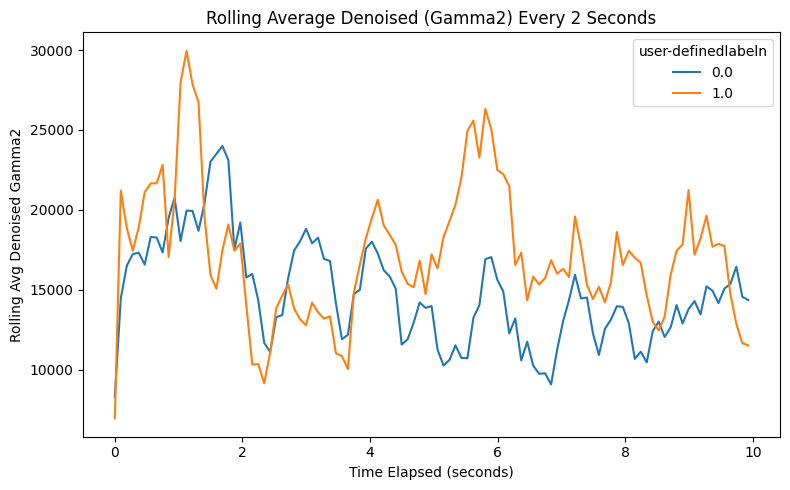

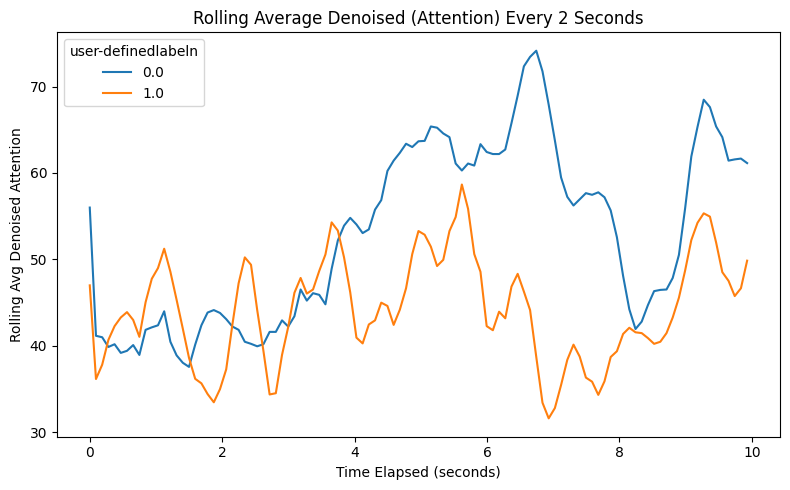

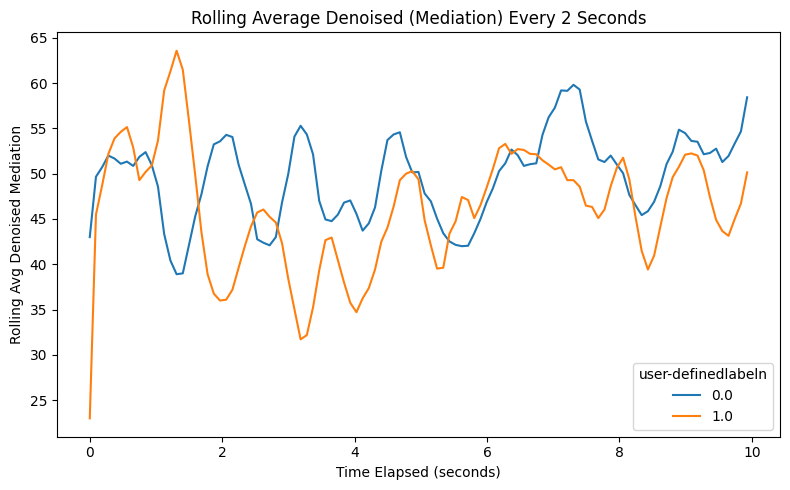

In [22]:
# Make a copy for rolling computation 
roll_df = time_df.copy()

# Sort by time to ensure correct rolling order
roll_df = roll_df.sort_values(['user-definedlabeln', 'seconds_elapsed'])

# Define brainwave columns
brainwave_cols = ['Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 
                  'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'Attention', 'Mediation']

# Known average sampling rate
avg_sampling_rate = 10.68  # rows per second

# Rolling window size in seconds
rolling_seconds = 2 
window_size = int(round(avg_sampling_rate * rolling_seconds))  

# Apply rolling average for each group
rolled = []
for label, group in roll_df.groupby('user-definedlabeln'):
    group = group.copy()
    group[brainwave_cols] = group[brainwave_cols].rolling(window=window_size, min_periods=1).mean()

    # Optional: downsample to reduce time steps (e.g., keep every 5th point)
    group = group.iloc[::5].reset_index(drop=True)
    rolled.append(group)

# Combine all groups back
roll_avg_df = pd.concat(rolled).reset_index(drop=True)

# Slice for plotting (first 10 seconds only)
slice_df = roll_avg_df[roll_avg_df['seconds_elapsed'] <= 10]

# Keep only user-definedlabeln and brainwave columns
roll_avg_df = roll_avg_df[['user-definedlabeln'] + brainwave_cols]

# Plot each brainwave smoothed
for col in brainwave_cols:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=slice_df, x='seconds_elapsed', y=col, hue='user-definedlabeln')
    plt.title(f'Rolling Average Denoised ({col}) Every {rolling_seconds} Seconds')
    plt.xlabel('Time Elapsed (seconds)')
    plt.ylabel(f'Rolling Avg Denoised {col}')
    plt.legend(title='user-definedlabeln')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()

# Analyze min and max to verify if scaling is needed after denoising for LSTM model
seconds_elapsed will not be used for LSTM since the data is at regular intervals

In [23]:
print('min values:\n', + roll_avg_df.min())
print('\nmax values:\n', + roll_avg_df.max())

min values:
 user-definedlabeln       0.000000
Raw                   -160.380952
Delta                 6935.714286
Theta                 9308.000000
Alpha1                4589.047619
Alpha2                4160.333333
Beta1                 4552.761905
Beta2                 4550.333333
Gamma1                2132.857143
Gamma2                1424.000000
Attention                1.904762
Mediation                4.809524
dtype: float64

max values:
 user-definedlabeln    1.000000e+00
Raw                   7.609048e+02
Delta                 1.346617e+06
Theta                 5.530860e+05
Alpha1                1.562766e+05
Alpha2                1.283020e+05
Beta1                 1.085973e+05
Beta2                 2.326288e+05
Gamma1                2.501520e+05
Gamma2                1.054490e+05
Attention             8.776190e+01
Mediation             7.476190e+01
dtype: float64


In [24]:
# Define scaler used
scaler = MinMaxScaler()

# Fit scaler only on brainwave columns
scaler.fit(roll_avg_df[brainwave_cols])

# Transform brainwave columns
roll_avg_df[brainwave_cols] = scaler.transform(roll_avg_df[brainwave_cols])

# Show new min and max
print('min values:\n', + roll_avg_df.min())
print('\nmax values:\n', + roll_avg_df.max())
print('\nunique value count:\n', + roll_avg_df.nunique())

min values:
 user-definedlabeln    0.0
Raw                   0.0
Delta                 0.0
Theta                 0.0
Alpha1                0.0
Alpha2                0.0
Beta1                 0.0
Beta2                 0.0
Gamma1                0.0
Gamma2                0.0
Attention             0.0
Mediation             0.0
dtype: float64

max values:
 user-definedlabeln    1.0
Raw                   1.0
Delta                 1.0
Theta                 1.0
Alpha1                1.0
Alpha2                1.0
Beta1                 1.0
Beta2                 1.0
Gamma1                1.0
Gamma2                1.0
Attention             1.0
Mediation             1.0
dtype: float64

unique value count:
 user-definedlabeln       2
Raw                   1714
Delta                 2563
Theta                 2561
Alpha1                2561
Alpha2                2556
Beta1                 2560
Beta2                 2561
Gamma1                2561
Gamma2                2557
Attention              976


# Visualizations

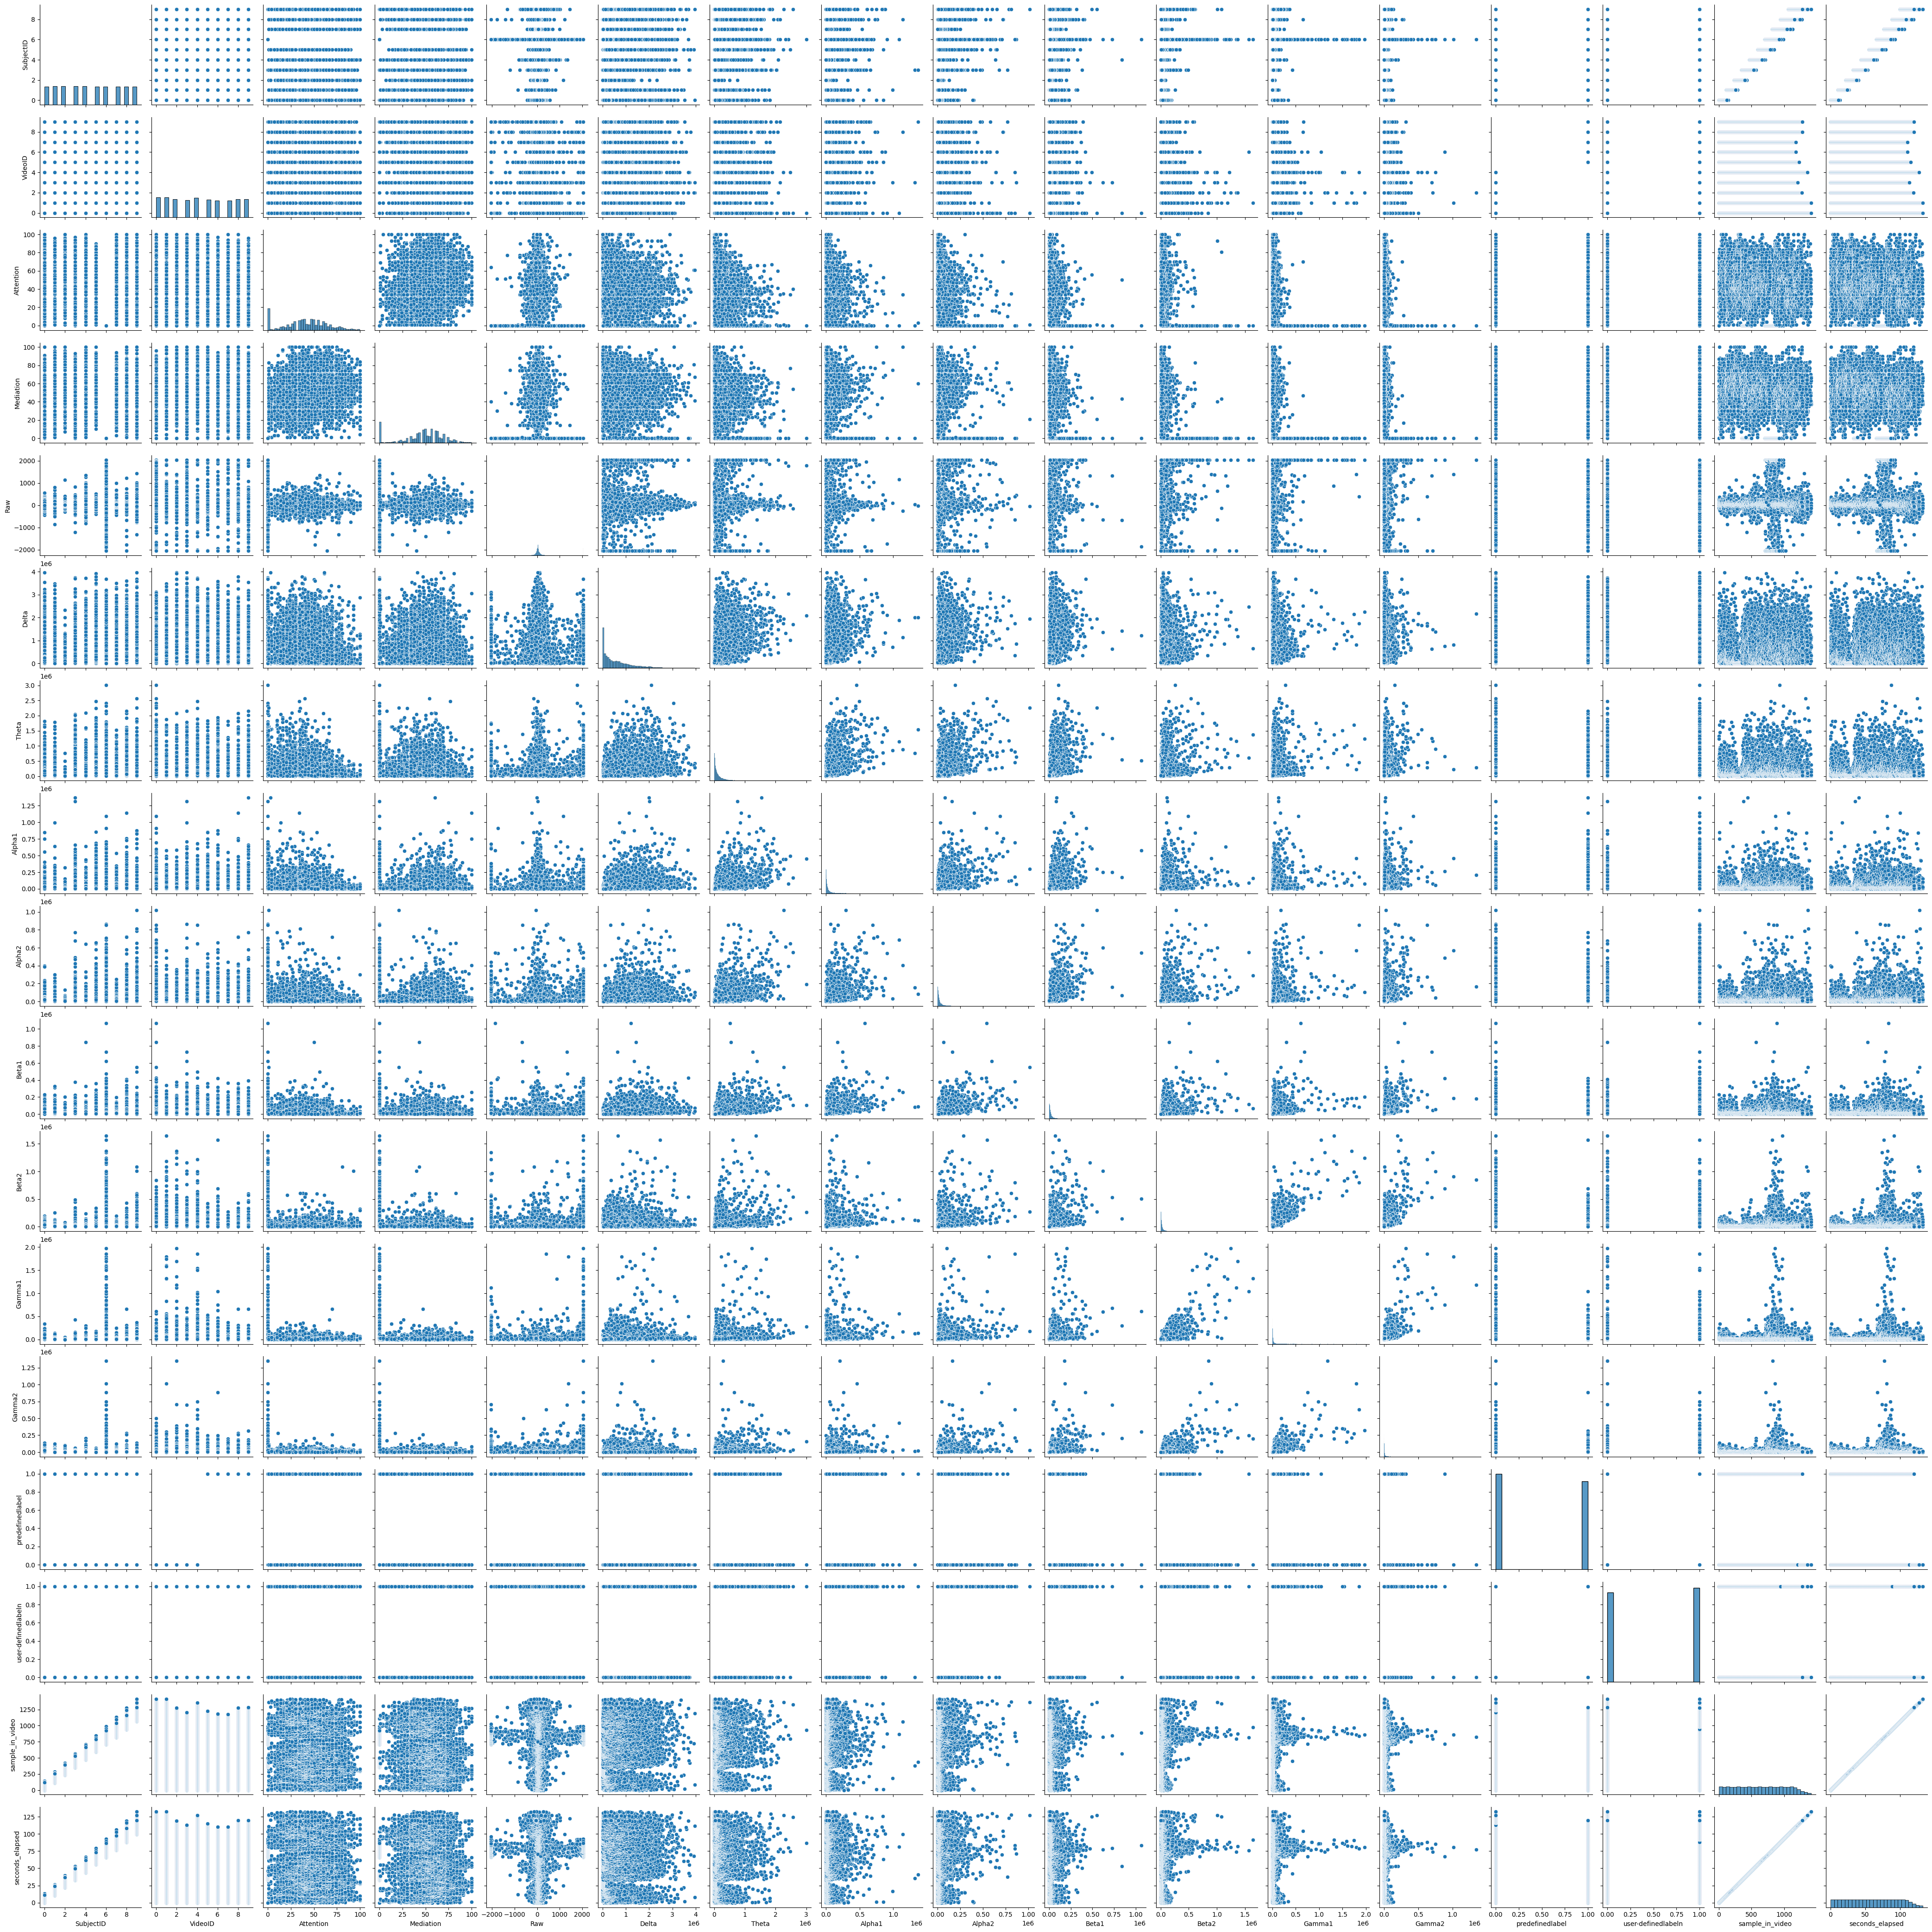

In [25]:
# Pairplot of all variables
sns.pairplot(time_df)

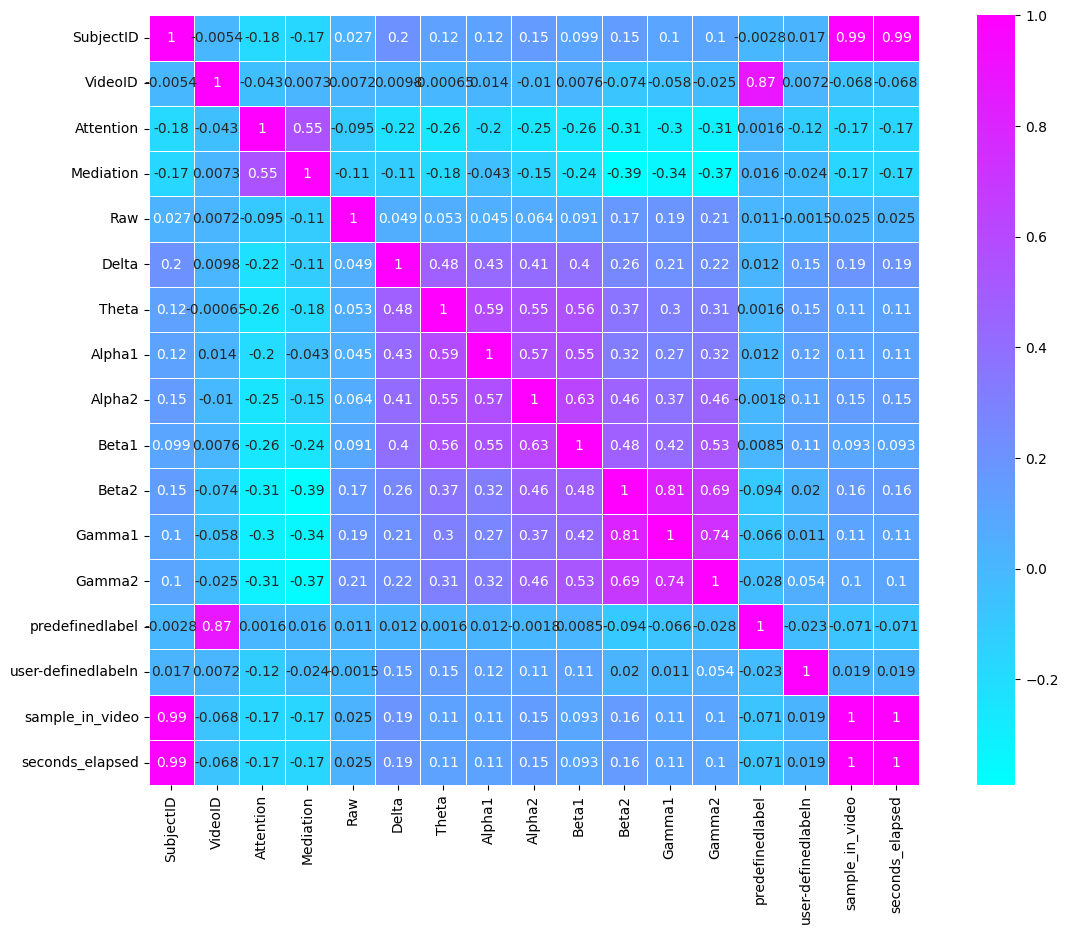

In [26]:
# Correlation matrix
plt.figure(figsize=(15,10)) # Width, height
sns.heatmap(time_df.corr(), annot=True, cmap='cool', linewidths=.5, square=True)
plt.show()

# Feature correlations - all features

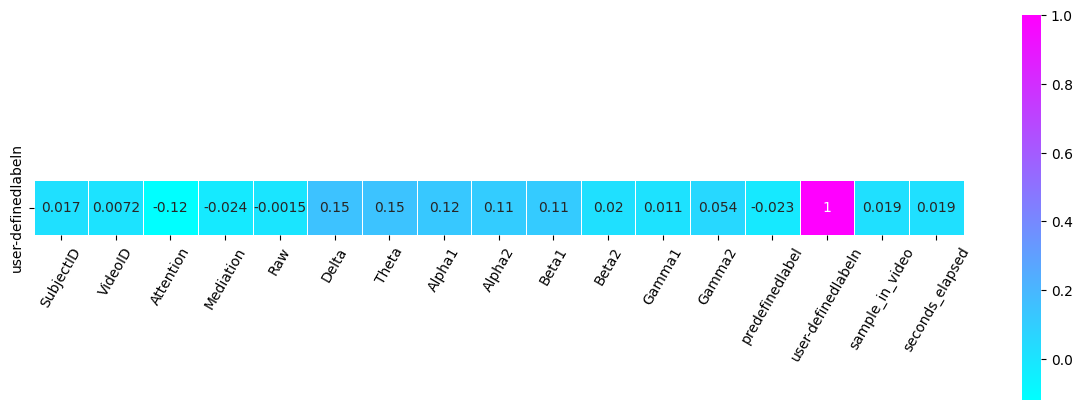

In [27]:
# Correlation matrix of target label
plt.figure(figsize=(15,5)) # Width, height
sns.heatmap(time_df.corr()[['user-definedlabeln']].T, annot=True, cmap='cool', linewidths=.5, square=True)
plt.xticks(rotation=60)
plt.show()

# Binned avg feature correlations
# + improved feature selection 
# + Denoised with binned average

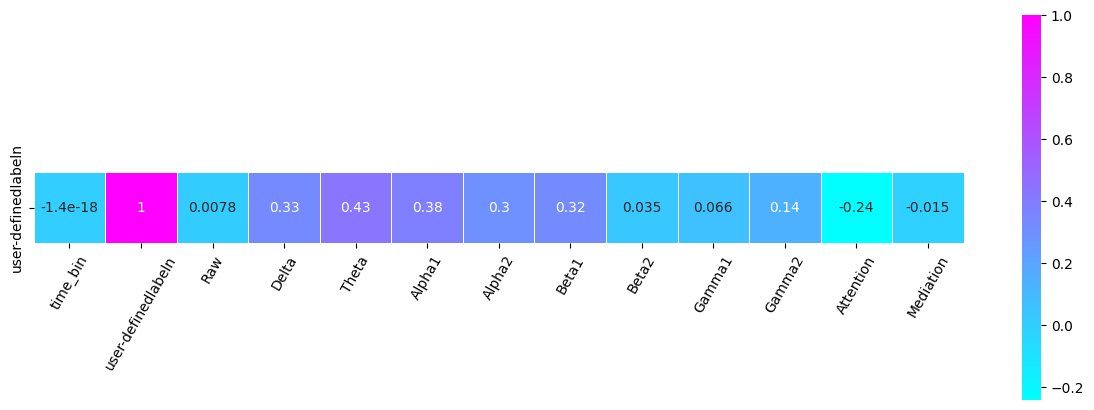

In [28]:
# Correlation matrix of target label
plt.figure(figsize=(15,5)) # Width, height
sns.heatmap(bin_avg_df.corr()[['user-definedlabeln']].T, annot=True, cmap='cool', linewidths=.5, square=True)
plt.xticks(rotation=60)
plt.show()

# Rolling avg correlations
# + improved feature selection 
# + Denoised with rolling average

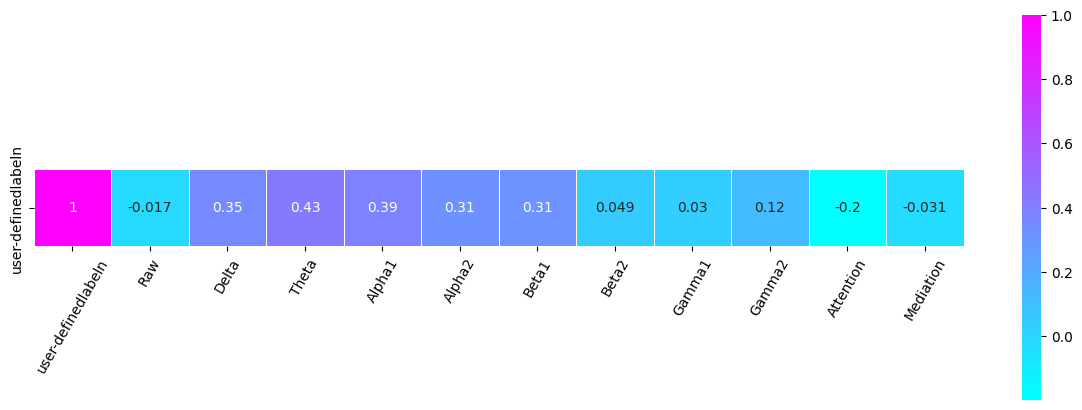

In [29]:
# Correlation matrix of target label
plt.figure(figsize=(15,5)) # Width, height
sns.heatmap(roll_avg_df.corr()[['user-definedlabeln']].T, annot=True, cmap='cool', linewidths=.5, square=True)
plt.xticks(rotation=60)
plt.show()

# Define data for first models

In [30]:
bin_avg_df.head()

time_bin  user-definedlabeln        Raw          Delta          Theta  \
0       0.0                 0.0  28.766667  757999.400000  182793.466667   
1       0.0                 1.0  39.500000  817392.233333  227675.700000   
2       0.5                 0.0  31.520000  678793.960000  228688.760000   
3       0.5                 1.0  17.680000  901936.600000  220486.680000   
4       1.0                 0.0  41.666667  696201.133333  205018.033333   

         Alpha1        Alpha2         Beta1         Beta2        Gamma1  \
0  37136.333333  23608.833333  20052.100000  42993.266667  35134.133333   
1  57189.200000  45275.200000  28508.966667  40671.100000  47203.266667   
2  43208.680000  30923.280000  25355.000000  45694.280000  47714.800000   
3  77749.960000  35511.440000  27313.800000  42328.640000  36360.680000   
4  31676.766667  28332.433333  24859.366667  41201.600000  44419.366667   

         Gamma2  Attention  Mediation  
0  16040.033333  39.633333  50.633333  
1  20013.633333  41.966667  53.233333  
2  19549.520000  42.000000  49.400000  
3  27656.480000  48.720000  52.440000  
4  21637.200000  38.466667  42.566667

# XGBoost MODEL 1 - Define x and y for training - all features

In [31]:
# Variables
X = raw_df.drop(['user-definedlabeln'], axis=1) # axis 1 = across columns
y = raw_df['user-definedlabeln']

In [32]:
X.head()

SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0  
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0  
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0  
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0  
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0

# XGBoost MODEL 1 - XGBoost Training - all features

In [33]:
# Split data into training and validation sets for early stopping (binary classification)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- XGBoost Model Training with Early Stopping (Binary Class) ---

print("--- Starting XGBoost Training with Early Stopping (Binary Class) ---")

model = xgb.XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # Use binary:logistic for binary classification
    eval_metric="logloss",        # Use logloss for binary classification
    random_state=42,
    early_stopping_rounds=50,
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

print("\n--- XGBoost Training Completed ---")

# --- 4. Access Best Iteration and Score ---
print(f"Best iteration (number of trees): {model.best_iteration}") 
print(f"Best validation score: {model.best_score}")


--- Starting XGBoost Training with Early Stopping (Binary Class) ---
[0]	validation_0-logloss:0.56751
[20]	validation_0-logloss:0.18542
[40]	validation_0-logloss:0.03447
[60]	validation_0-logloss:0.01718
[80]	validation_0-logloss:0.00820
[100]	validation_0-logloss:0.00591
[120]	validation_0-logloss:0.00479
[140]	validation_0-logloss:0.00374
[160]	validation_0-logloss:0.00308
[180]	validation_0-logloss:0.00268
[200]	validation_0-logloss:0.00249
[220]	validation_0-logloss:0.00234
[240]	validation_0-logloss:0.00226
[260]	validation_0-logloss:0.00218
[280]	validation_0-logloss:0.00205
[300]	validation_0-logloss:0.00194
[320]	validation_0-logloss:0.00186
[340]	validation_0-logloss:0.00183
[360]	validation_0-logloss:0.00178
[380]	validation_0-logloss:0.00175
[400]	validation_0-logloss:0.00172
[420]	validation_0-logloss:0.00171
[440]	validation_0-logloss:0.00170
[460]	validation_0-logloss:0.00169
[480]	validation_0-logloss:0.00170
[500]	validation_0-logloss:0.00169
[520]	validation_0-logloss:

# XGBoost Model 1 - Performance

In [34]:
# Predict class probabilities
y_val_proba = model.predict_proba(X_val)

# Predict class labels
y_val_pred = model.predict(X_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Log loss (multi-class logloss, same as eval_metric)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Validation Log Loss: {val_logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report (precision, recall, f1-score, ROC-AUC)
report = classification_report(y_val, y_val_pred, target_names=[str(cls) for cls in model.classes_])
print("\nClassification Report:")
print(report)
print("ROC-AUC Score:", round(roc_auc_score(y_val, y_val_proba[:, 1]), 4)) # For positive class


Validation Accuracy: 1.0000
Validation Log Loss: 0.0016

Confusion Matrix:
[[1249    0]
 [   0 1314]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1249
           1       1.00      1.00      1.00      1314

    accuracy                           1.00      2563
   macro avg       1.00      1.00      1.00      2563
weighted avg       1.00      1.00      1.00      2563

ROC-AUC Score: 1.0


# XGBoost MODEL 1 - Shap value for feature correlation - all features

100%|===================| 12802/12811 [08:19<00:00]        

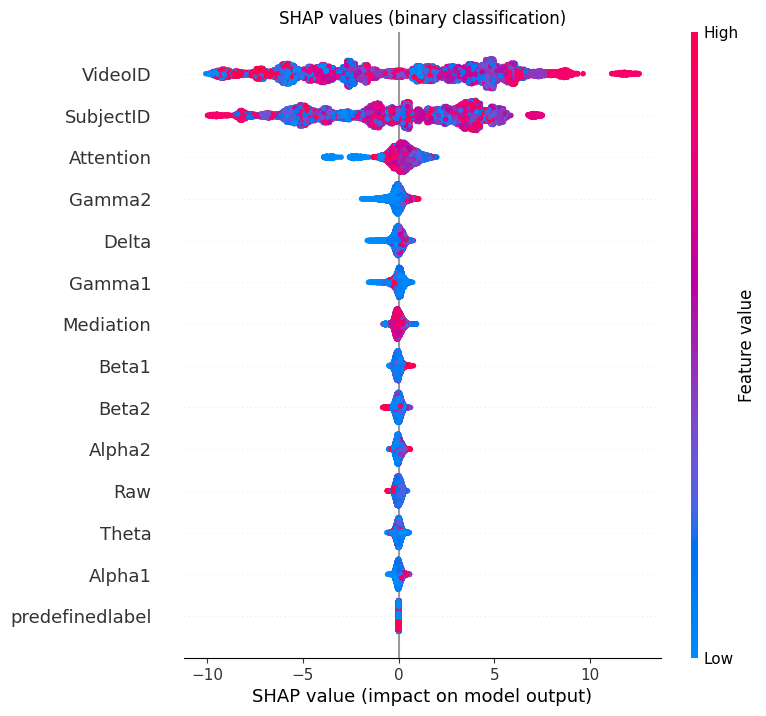

In [35]:
# Explain the model with SHAP
explainer = shap.Explainer(model, X)
# Shap values that explain X positive class
shap_values = explainer(X)
# SHAP values for binary classification - shape: (n_samples, n_features) - one SHAP value per feature, per sample.
shap_values_matrix = shap_values.values 

# SHAP values for each class
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_matrix,
    X.values,
    feature_names=X.columns,
    show=False
)
plt.title("SHAP values (binary classification)")
plt.show()

# Dropping columns 

The VideoID and SubjectID have a very strong influence, but only within small ranges of inputs with poor target value separation. 

These features seem less practical for generalizing to other real world data to predict human emotion based on EEG data. We will re-test SHAP values without these features.

Real world EEG data for this application would also likely not contain the supplied predefined label where the subjects were expected to be confused, so this column will also be removed.

# XGBoost MODEL 2 - XGBoost Training 
# + improved feature selection

In [36]:
# Remove VideoID and SubjectID
selected_df = raw_df.drop(['VideoID', 'SubjectID','predefinedlabel'], axis = 1)

# Variables
X = selected_df.drop(['user-definedlabeln'], axis=1) # axis 1 = across columns
y = raw_df['user-definedlabeln']

In [37]:
# Split data into training and validation sets for early stopping (binary classification)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check distributions
print("y_val distribution:", np.bincount(y_val))
print("y_val_pred distribution:", np.bincount(y_val_pred))

# --- XGBoost Model Training with Early Stopping (Binary Class) ---

print("--- Starting XGBoost Training with Early Stopping (Binary Class) ---")

model = xgb.XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # Use binary:logistic for binary classification
    eval_metric="logloss",        # Use logloss for binary classification
    random_state=42,
    early_stopping_rounds=50,
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

print("\n--- XGBoost Training Completed ---")

# --- 4. Access Best Iteration and Score ---
print(f"Best iteration (number of trees): {model.best_iteration}")
print(f"Best validation score: {model.best_score}")


y_val distribution: [1249 1314]
y_val_pred distribution: [1249 1314]
--- Starting XGBoost Training with Early Stopping (Binary Class) ---
[0]	validation_0-logloss:0.67119
[20]	validation_0-logloss:0.62775
[40]	validation_0-logloss:0.63374
[60]	validation_0-logloss:0.63960
[64]	validation_0-logloss:0.64094

--- XGBoost Training Completed ---
Best iteration (number of trees): 15
Best validation score: 0.6262586843723833


# XGBoost Model 2 - Performance

In [38]:
# Predict class probabilities
y_val_proba = model.predict_proba(X_val)

# Predict class labels
y_val_pred = model.predict(X_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Log loss (multi-class logloss, same as eval_metric)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Validation Log Loss: {val_logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report (precision, recall, f1-score, ROC-AUC)
report = classification_report(y_val, y_val_pred, target_names=[str(cls) for cls in model.classes_])
print("\nClassification Report:")
print(report)
print("ROC-AUC Score:", round(roc_auc_score(y_val, y_val_proba[:, 1]), 4)) # For positive class


Validation Accuracy: 0.6547
Validation Log Loss: 0.6263

Confusion Matrix:
[[782 467]
 [418 896]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1249
           1       0.66      0.68      0.67      1314

    accuracy                           0.65      2563
   macro avg       0.65      0.65      0.65      2563
weighted avg       0.65      0.65      0.65      2563

ROC-AUC Score: 0.7048


# XGBoost MODEL 2 - Shap value for refined features
# + improved feature selection

In [39]:
print(shap_values.values.shape)

(12811, 14)


100%|===================| 12768/12811 [00:18<00:00]        

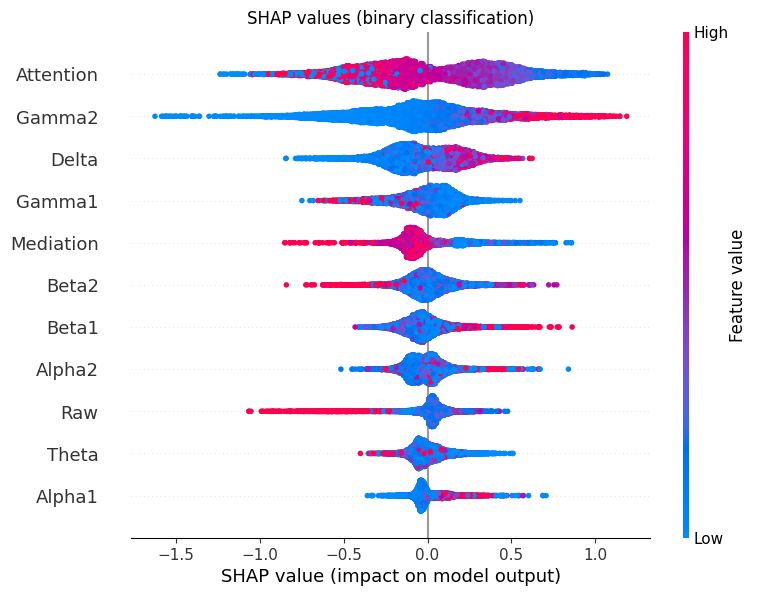

In [40]:
# Explain the model with SHAP
explainer = shap.Explainer(model, X)
# Shap values that explain X positive class
shap_values = explainer(X)
# SHAP values for binary classification - shape: (n_samples, n_features) - one SHAP value per feature, per sample.
shap_values_matrix = shap_values.values 

# SHAP values for each class
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_matrix,
    X.values,
    feature_names=X.columns,
    show=False
)
plt.title("SHAP values (binary classification)")
plt.show()

# each feature in the brainwave data appears to have decent influence on the target variable with adequate target value separation depending on the feature value

# XGBoost MODEL 3 - XGBoost Training and Shap values
# + improved feature selection
# + binned average denoising

In [41]:
bin_avg_df.head()

time_bin  user-definedlabeln        Raw          Delta          Theta  \
0       0.0                 0.0  28.766667  757999.400000  182793.466667   
1       0.0                 1.0  39.500000  817392.233333  227675.700000   
2       0.5                 0.0  31.520000  678793.960000  228688.760000   
3       0.5                 1.0  17.680000  901936.600000  220486.680000   
4       1.0                 0.0  41.666667  696201.133333  205018.033333   

         Alpha1        Alpha2         Beta1         Beta2        Gamma1  \
0  37136.333333  23608.833333  20052.100000  42993.266667  35134.133333   
1  57189.200000  45275.200000  28508.966667  40671.100000  47203.266667   
2  43208.680000  30923.280000  25355.000000  45694.280000  47714.800000   
3  77749.960000  35511.440000  27313.800000  42328.640000  36360.680000   
4  31676.766667  28332.433333  24859.366667  41201.600000  44419.366667   

         Gamma2  Attention  Mediation  
0  16040.033333  39.633333  50.633333  
1  20013.633333  41.966667  53.233333  
2  19549.520000  42.000000  49.400000  
3  27656.480000  48.720000  52.440000  
4  21637.200000  38.466667  42.566667

In [42]:
# Variables
X = bin_avg_df.drop(['user-definedlabeln', 'time_bin'], axis=1) # axis 1 = across columns
y = bin_avg_df['user-definedlabeln']

In [43]:
X.head()

Raw          Delta          Theta        Alpha1        Alpha2  \
0  28.766667  757999.400000  182793.466667  37136.333333  23608.833333   
1  39.500000  817392.233333  227675.700000  57189.200000  45275.200000   
2  31.520000  678793.960000  228688.760000  43208.680000  30923.280000   
3  17.680000  901936.600000  220486.680000  77749.960000  35511.440000   
4  41.666667  696201.133333  205018.033333  31676.766667  28332.433333   

          Beta1         Beta2        Gamma1        Gamma2  Attention  \
0  20052.100000  42993.266667  35134.133333  16040.033333  39.633333   
1  28508.966667  40671.100000  47203.266667  20013.633333  41.966667   
2  25355.000000  45694.280000  47714.800000  19549.520000  42.000000   
3  27313.800000  42328.640000  36360.680000  27656.480000  48.720000   
4  24859.366667  41201.600000  44419.366667  21637.200000  38.466667   

   Mediation  
0  50.633333  
1  53.233333  
2  49.400000  
3  52.440000  
4  42.566667

In [44]:
# Split data into training and validation sets for early stopping (binary classification)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Check distributions
print("y_val distribution:", np.bincount(y_val))
print("y_val_pred distribution:", np.bincount(y_val_pred))


# --- XGBoost Model Training with Early Stopping (Binary Class) ---

print("--- Starting XGBoost Training with Early Stopping (Binary Class) ---")

model = xgb.XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # Use binary:logistic for binary classification
    eval_metric="logloss",        # Use logloss for binary classification
    random_state=42,
    early_stopping_rounds=50,
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

print("\n--- XGBoost Training Completed ---")

# --- 4. Access Best Iteration and Score ---
print(f"Best iteration (number of trees): {model.best_iteration}")
print(f"Best validation score: {model.best_score}")


y_val distribution: [53 53]
y_val_pred distribution: [1200 1363]
--- Starting XGBoost Training with Early Stopping (Binary Class) ---
[0]	validation_0-logloss:0.60079
[20]	validation_0-logloss:0.49842
[40]	validation_0-logloss:0.55259
[60]	validation_0-logloss:0.58346
[63]	validation_0-logloss:0.58100

--- XGBoost Training Completed ---
Best iteration (number of trees): 14
Best validation score: 0.4739835851579764


# XGBoost Model 3 - Performance

In [45]:
# Predict class probabilities
y_val_proba = model.predict_proba(X_val)

# Predict class labels
y_val_pred = model.predict(X_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Log loss (multi-class logloss, same as eval_metric)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Validation Log Loss: {val_logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report (precision, recall, f1-score, ROC-AUC)
report = classification_report(y_val, y_val_pred, target_names=[str(cls) for cls in model.classes_])
print("\nClassification Report:")
print(report)
print("ROC-AUC Score:", round(roc_auc_score(y_val, y_val_proba[:, 1]), 4)) # For positive class


Validation Accuracy: 0.7830
Validation Log Loss: 0.4740

Confusion Matrix:
[[43 10]
 [13 40]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        53
           1       0.80      0.75      0.78        53

    accuracy                           0.78       106
   macro avg       0.78      0.78      0.78       106
weighted avg       0.78      0.78      0.78       106

ROC-AUC Score: 0.8797


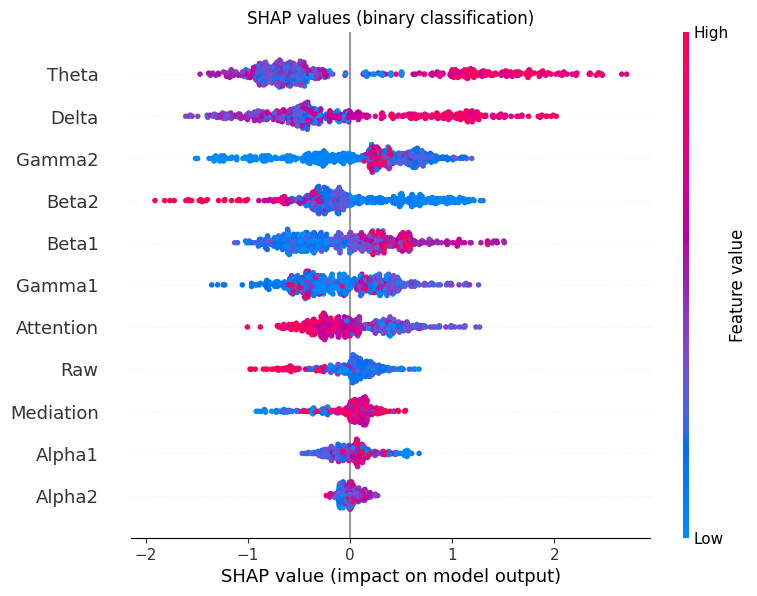

In [46]:
# Explain the model with SHAP
explainer = shap.Explainer(model, X)
# Shap values that explain X positive class
shap_values = explainer(X)
# SHAP values for binary classification - shape: (n_samples, n_features) - one SHAP value per feature, per sample.
shap_values_matrix = shap_values.values 

# SHAP values for each class
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_matrix,
    X.values,
    feature_names=X.columns,
    show=False
)
plt.title("SHAP values (binary classification)")
plt.show()

# Model Development and Training

# - **Random Forest**: Handles feature interactions well
# - **Support Vector Machine (SVM)**: Effective for high-dimensional data
# - **Neural Network (MLP)**: Can capture complex patterns


We'll implement and compare multiple machine learning algorithms suitable for EEG classification:

Feature matrix shape: (530, 11)
Target vector shape: (530,)

Training set: 424 samples
Test set: 106 samples
Training target class distribution: [212 212]
Test target class distribution: [53 53]

Features scaled using StandardScaler
Scaled training data shape: (424, 11)


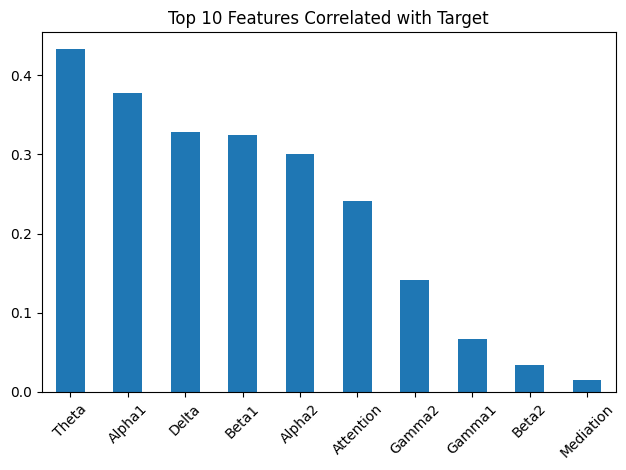

In [74]:
# Define features for modeling
X = bin_avg_df.drop(['user-definedlabeln', 'time_bin'], axis=1) # axis 1 = across columns
y = bin_avg_df['user-definedlabeln']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training target class distribution: {np.bincount(y_train)}")
print(f"Test target class distribution: {np.bincount(y_test)}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled using StandardScaler")
print(f"Scaled training data shape: {X_train_scaled.shape}")

# Correlation with target
feature_correlations = bin_avg_df.corr()['user-definedlabeln'].abs().sort_values(ascending=False)[1:11]
feature_correlations.plot(kind='bar')
plt.title('Top 10 Features Correlated with Target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Train and evaluate models
model_results = {}
trained_models = {}

print("Training Models...")
print("=" * 50)

for name, model in models.items():
    print(f"\n Training {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = model.score(X_test_scaled, y_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    model_results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    
    print(f" {name} completed!")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n All models trained successfully!")

Training Models...

 Training Random Forest...
 Random Forest completed!
   Accuracy: 0.8302
   ROC-AUC: 0.8984
   CV Score: 0.7995 (±0.0307)

 Training SVM...
 SVM completed!
   Accuracy: 0.7736
   ROC-AUC: 0.8622
   CV Score: 0.7522 (±0.0335)

 Training Neural Network...
 Neural Network completed!
   Accuracy: 0.8302
   ROC-AUC: 0.8843
   CV Score: 0.7759 (±0.0305)

 All models trained successfully!


## Model Evaluation and Comparison

Let's comprehensively evaluate our models using multiple metrics and visualizations.


 MODEL PERFORMANCE COMPARISON
         Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV Mean  CV Std
 Random Forest    0.8302     0.8302  0.8302    0.8302   0.8984   0.7995  0.0307
           SVM    0.7736     0.8085  0.7170    0.7600   0.8622   0.7522  0.0335
Neural Network    0.8302     0.8070  0.8679    0.8364   0.8843   0.7759  0.0305

 Best performing model: Random Forest
 Best accuracy: 0.8302


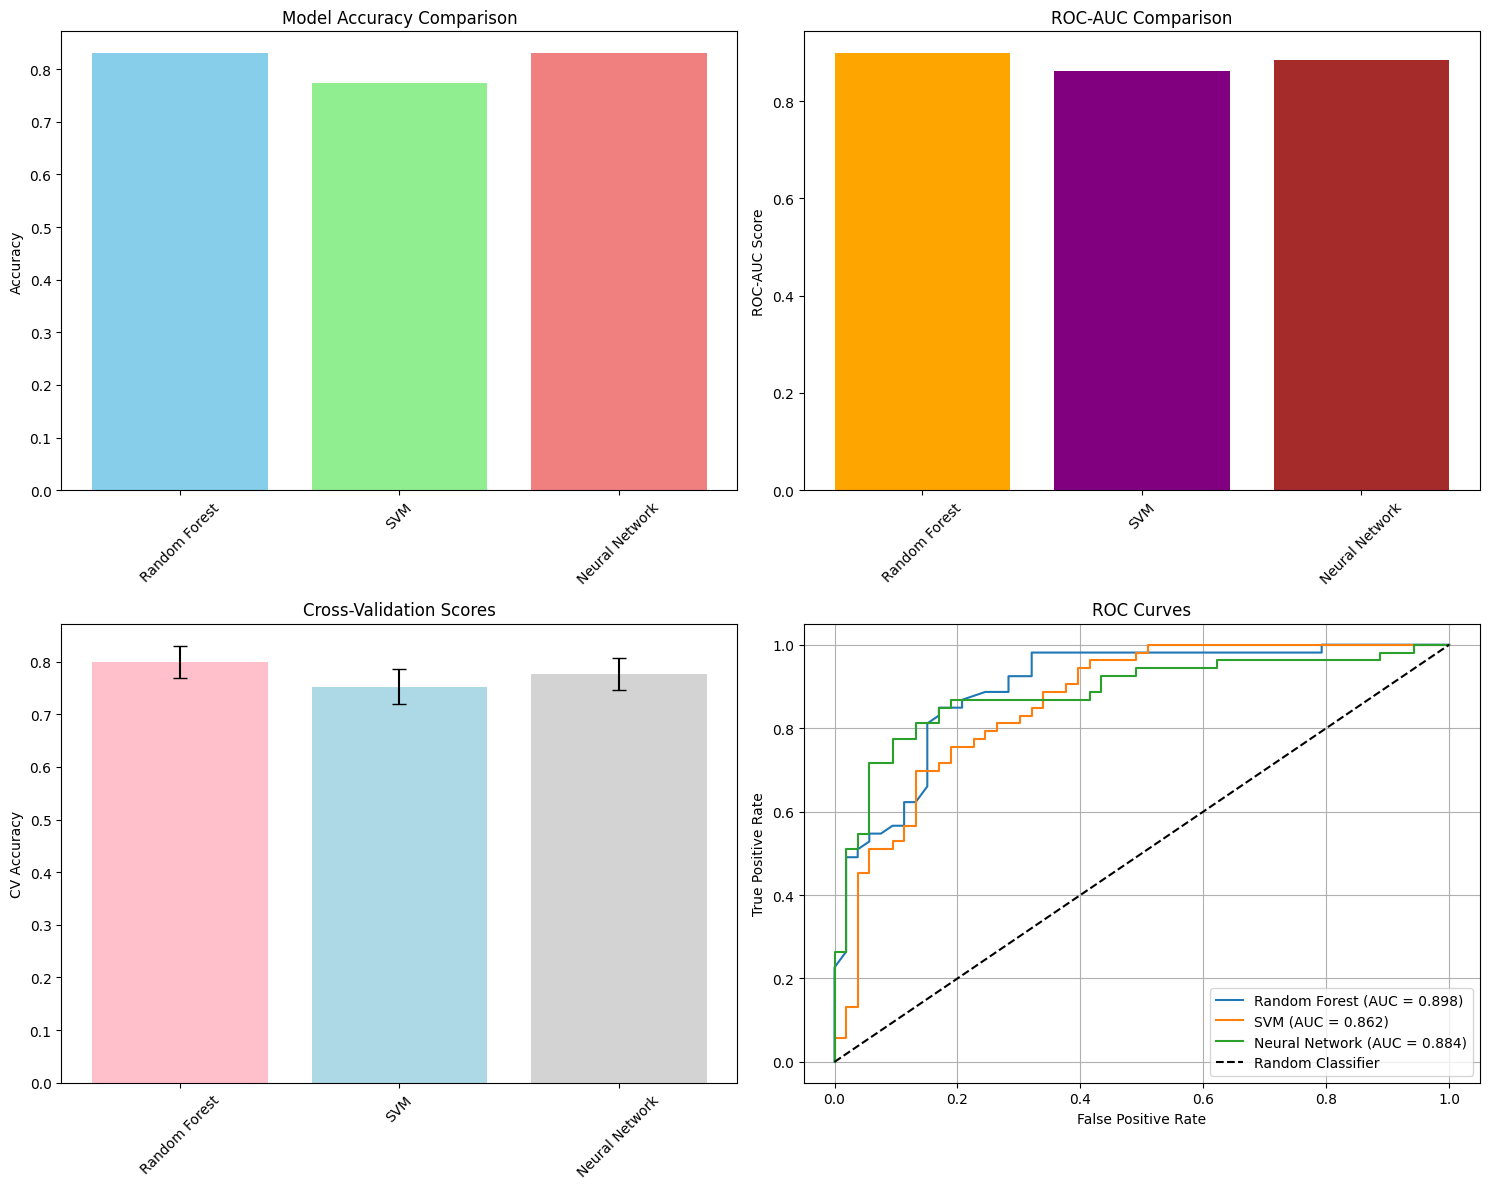

In [76]:
# Create comprehensive evaluation report
print(" MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[model]['accuracy'] for model in model_results],
    'Precision': [model_results[model]['precision'] for model in model_results],
    'Recall': [model_results[model]['recall'] for model in model_results],
    'F1-Score': [model_results[model]['f1'] for model in model_results],
    'ROC-AUC': [model_results[model]['roc_auc'] for model in model_results],
    'CV Mean': [model_results[model]['cv_mean'] for model in model_results],
    'CV Std': [model_results[model]['cv_std'] for model in model_results]
})

print(results_df.to_string(index=False, float_format='%.4f'))

# Find best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f"\n Best performing model: {best_model_name}")
print(f" Best accuracy: {results_df['Accuracy'].max():.4f}")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
axes[0, 0].bar(results_df['Model'], results_df['Accuracy'], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# ROC-AUC comparison
axes[0, 1].bar(results_df['Model'], results_df['ROC-AUC'], color=['orange', 'purple', 'brown'])
axes[0, 1].set_title('ROC-AUC Comparison')
axes[0, 1].set_ylabel('ROC-AUC Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Cross-validation scores with error bars
axes[1, 0].bar(results_df['Model'], results_df['CV Mean'], 
               yerr=results_df['CV Std'], capsize=5, color=['pink', 'lightblue', 'lightgray'])
axes[1, 0].set_title('Cross-Validation Scores')
axes[1, 0].set_ylabel('CV Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)

# ROC Curves
for name in model_results.keys():
    fpr, tpr, _ = roc_curve(y_test, model_results[name]['probabilities'])
    axes[1, 1].plot(fpr, tpr, label=f"{name} (AUC = {model_results[name]['roc_auc']:.3f})")

axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curves')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()




DETAILED ANALYSIS: Random Forest

Classification Report:
              precision    recall  f1-score   support

     Focused       0.83      0.83      0.83        53
    Confused       0.83      0.83      0.83        53

    accuracy                           0.83       106
   macro avg       0.83      0.83      0.83       106
weighted avg       0.83      0.83      0.83       106



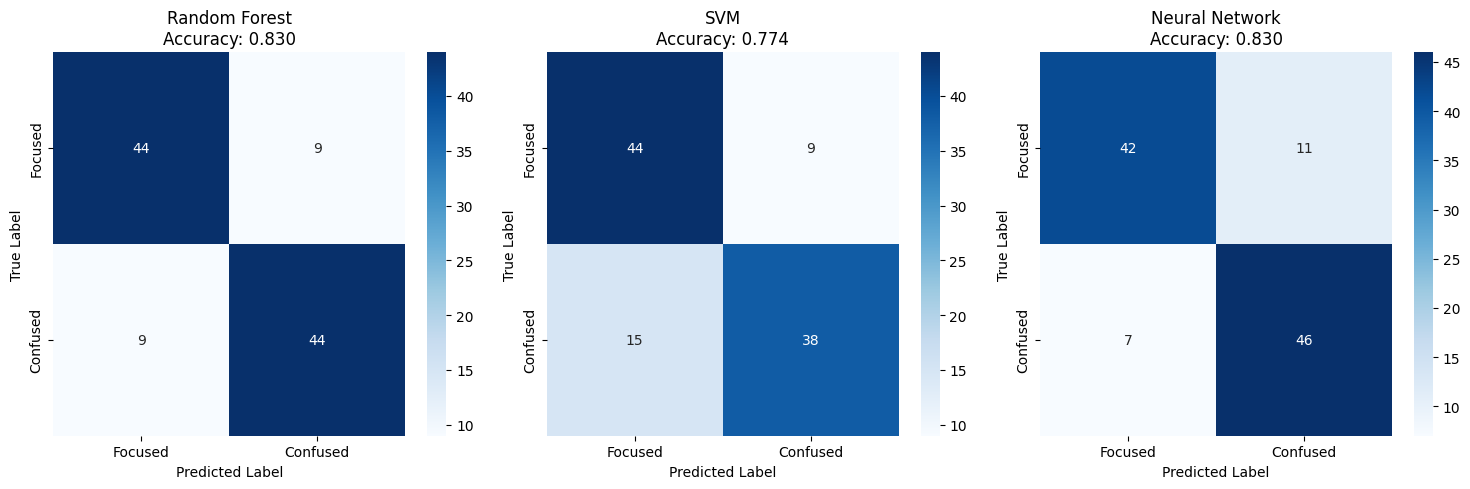


Top 10 Most Important Features (Random Forest):
  feature  importance
    Theta      0.1929
    Delta      0.1280
   Alpha1      0.0998
   Gamma2      0.0897
   Gamma1      0.0878
    Beta1      0.0821
    Beta2      0.0770
Attention      0.0673
Mediation      0.0636
      Raw      0.0572


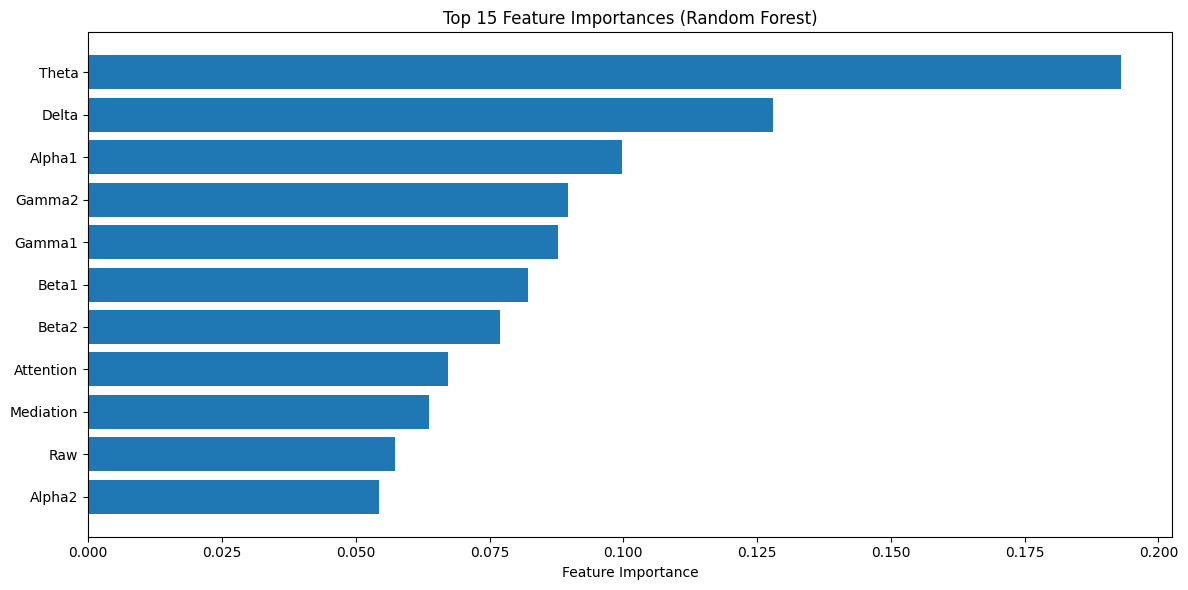

In [84]:
# DETAILED ANALYSIS
best_model = trained_models[best_model_name]
best_predictions = model_results[best_model_name]['predictions']

print(f"\n\nDETAILED ANALYSIS: {best_model_name}")
print("=" * 50)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=['Focused', 'Confused']))

# Confusion Matrix
plt.figure(figsize=(15, 5))
for i, (name, results) in enumerate(model_results.items()):
    plt.subplot(1, len(model_results), i+1)
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Focused', 'Confused'],
                yticklabels=['Focused', 'Confused'])
    plt.title(f'{name}\nAccuracy: {results["accuracy"]:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature Importance (Random Forest only)
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features (Random Forest):")
    print(feature_importance.head(10).to_string(index=False, float_format='%.4f'))

    plt.figure(figsize=(12, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [88]:
# HYPERPARAMETER TUNING
print(f"\n\nOptimizing {best_model_name}...")

# Minimal grids for stability
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50],
        'max_depth': [10],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    }
    base_model = RandomForestClassifier(random_state=42)

elif best_model_name == 'SVM':
    param_grid = {
        'C': [1],
        'gamma': ['scale'],
        'kernel': ['rbf']
    }
    base_model = SVC(random_state=42, probability=True)

else:  # Neural Network
    param_grid = {
        'hidden_layer_sizes': [(100,)],
        'alpha': [0.001],
        'learning_rate': ['constant']
    }
    base_model = MLPClassifier(max_iter=1000, random_state=42)

# Perform Grid Search
print("Performing Grid Search (lightweight test)...")
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=3,                # reduced CV for memory safety
    scoring='accuracy',
    n_jobs=1,            # run single-threaded
    verbose=2,
    error_score='raise'
)

# Fit model
grid_search.fit(X_train_scaled, y_train)

# Get results
best_optimized_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate
optimized_predictions = best_optimized_model.predict(X_test_scaled)

# If predict_proba available, use it for ROC-AUC
if hasattr(best_optimized_model, "predict_proba"):
    optimized_probabilities = best_optimized_model.predict_proba(X_test_scaled)[:, 1]
else:
    optimized_probabilities = optimized_predictions  # fallback

optimized_accuracy = best_optimized_model.score(X_test_scaled, y_test)
optimized_roc_auc = roc_auc_score(y_test, optimized_probabilities)

print(f"\nOptimization completed!")
print(f"Best parameters: {best_params}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Performance Comparison
print(f"\n OPTIMIZED MODEL PERFORMANCE:")
print(f"Test Accuracy: {optimized_accuracy:.4f}")
print(f"ROC-AUC: {optimized_roc_auc:.4f}")
print(f"Accuracy Improvement: {optimized_accuracy - model_results[best_model_name]['accuracy']:.4f}")

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC'],
    'Original': [model_results[best_model_name]['accuracy'], model_results[best_model_name]['roc_auc']],
    'Optimized': [optimized_accuracy, optimized_roc_auc]
})
comparison_df['Improvement'] = comparison_df['Optimized'] - comparison_df['Original']

print(f"\nPerformance Comparison:")
print(comparison_df.to_string(index=False, float_format='%.4f'))



Optimizing Random Forest...
Performing Grid Search (lightweight test)...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s

Optimization completed!
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 0.7571

 OPTIMIZED MODEL PERFORMANCE:
Test Accuracy: 0.8208
ROC-AUC: 0.8848
Accuracy Improvement: -0.0094

Performance Comparison:
  Metric  Original  Optimized  Improvement
Accuracy    0.8302     0.8208      -0.0094
 ROC-AUC    0.8984     0.8848      -0.0135


In [89]:
# Deployment Analysis
print(" DEPLOYMENT ANALYSIS")
print("=" * 50)

# 1. Model Size and Serialization
print("\nModel Storage Requirements:")
for name, model in trained_models.items():
    # Serialize model to get size
    model_bytes = pickle.dumps(model)
    size_mb = len(model_bytes) / (1024 * 1024)
    print(f"   {name}: {size_mb:.2f} MB")

# 2. Inference Speed Analysis
print("\n Inference Speed Analysis:")
test_sample = X_test_scaled[:100]  # 100 samples for speed test

for name, model in trained_models.items():
    start_time = time.time()
    predictions = model.predict(test_sample)
    end_time = time.time()
    
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    per_sample_time = inference_time / len(test_sample)
    
    print(f"   {name}:")
    print(f"     Total time (100 samples): {inference_time:.2f} ms")
    print(f"     Per sample: {per_sample_time:.2f} ms")
    print(f"     Throughput: {1000/per_sample_time:.0f} samples/second")

# 3. Deployment Scenarios
deployment_scenarios = {
    "Real-time E-learning": {
        "latency_requirement": "< 100ms",
        "accuracy_requirement": "> 85%",
        "deployment_type": "Edge device or cloud API",
        "considerations": ["Battery life", "Privacy", "Network connectivity"]
    },
    "Clinical Assessment": {
        "latency_requirement": "< 1s",
        "accuracy_requirement": "> 90%",
        "deployment_type": "Secure cloud or on-premise",
        "considerations": ["HIPAA compliance", "Data security", "Audit trails"]
    },
    "Research Platform": {
        "latency_requirement": "< 5s",
        "accuracy_requirement": "> 80%",
        "deployment_type": "Batch processing",
        "considerations": ["Scalability", "Cost efficiency", "Data storage"]
    }
}

print(f"\nDEPLOYMENT SCENARIOS:")
for scenario, requirements in deployment_scenarios.items():
    print(f"\n {scenario}:")
    for key, value in requirements.items():
        if isinstance(value, list):
            print(f"   {key}: {', '.join(value)}")
        else:
            print(f"   {key}: {value}")

# 4. Model Recommendation
print(f"\nDEPLOYMENT RECOMMENDATION:")
print(f"Best model for deployment: {best_model_name}")
print(f"Optimized accuracy: {optimized_accuracy:.4f}")

# Check if model meets requirements
meets_realtime = per_sample_time < 100  # 100ms requirement
meets_accuracy = optimized_accuracy > 0.85

print(f"\n Real-time suitability: {'Yes' if meets_realtime else 'No'}")
print(f"Accuracy requirement: {'Yes' if meets_accuracy else 'No'}")

if meets_realtime and meets_accuracy:
    print("Model is suitable for real-time deployment!")
else:
    print("Model may need further optimization for real-time use.")

 DEPLOYMENT ANALYSIS

💾 Model Storage Requirements:
   Random Forest: 0.88 MB
   SVM: 0.03 MB
   Neural Network: 0.21 MB

 Inference Speed Analysis:
   Random Forest:
     Total time (100 samples): 4.00 ms
     Per sample: 0.04 ms
     Throughput: 25011 samples/second
   SVM:
     Total time (100 samples): 1.00 ms
     Per sample: 0.01 ms
     Throughput: 99841 samples/second
   Neural Network:
     Total time (100 samples): 1.00 ms
     Per sample: 0.01 ms
     Throughput: 100055 samples/second

 DEPLOYMENT SCENARIOS:

 Real-time E-learning:
   latency_requirement: < 100ms
   accuracy_requirement: > 85%
   deployment_type: Edge device or cloud API
   considerations: Battery life, Privacy, Network connectivity

 Clinical Assessment:
   latency_requirement: < 1s
   accuracy_requirement: > 90%
   deployment_type: Secure cloud or on-premise
   considerations: HIPAA compliance, Data security, Audit trails

 Research Platform:
   latency_requirement: < 5s
   accuracy_requirement: > 80%
   d

# Prepare LogisticRegression Model 1
# + binned averages
# + improved feature selection

In [51]:
bin_avg_df.head()

time_bin  user-definedlabeln        Raw          Delta          Theta  \
0       0.0                 0.0  28.766667  757999.400000  182793.466667   
1       0.0                 1.0  39.500000  817392.233333  227675.700000   
2       0.5                 0.0  31.520000  678793.960000  228688.760000   
3       0.5                 1.0  17.680000  901936.600000  220486.680000   
4       1.0                 0.0  41.666667  696201.133333  205018.033333   

         Alpha1        Alpha2         Beta1         Beta2        Gamma1  \
0  37136.333333  23608.833333  20052.100000  42993.266667  35134.133333   
1  57189.200000  45275.200000  28508.966667  40671.100000  47203.266667   
2  43208.680000  30923.280000  25355.000000  45694.280000  47714.800000   
3  77749.960000  35511.440000  27313.800000  42328.640000  36360.680000   
4  31676.766667  28332.433333  24859.366667  41201.600000  44419.366667   

         Gamma2  Attention  Mediation  
0  16040.033333  39.633333  50.633333  
1  20013.633333  41.966667  53.233333  
2  19549.520000  42.000000  49.400000  
3  27656.480000  48.720000  52.440000  
4  21637.200000  38.466667  42.566667

Accuracy: 0.7075471698113207
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72        53
         1.0       0.72      0.68      0.70        53

    accuracy                           0.71       106
   macro avg       0.71      0.71      0.71       106
weighted avg       0.71      0.71      0.71       106

ROC-AUC: 0.7767888928444286


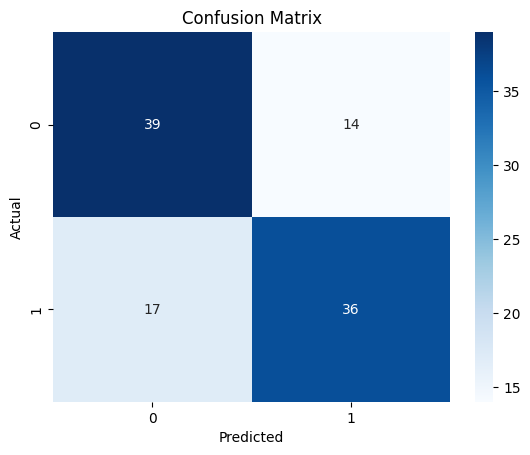

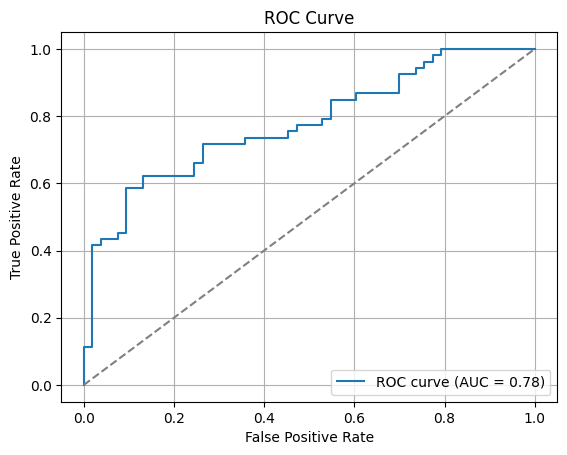

In [52]:
# Define features for modeling
X = bin_avg_df.drop(['user-definedlabeln', 'time_bin'], axis=1)
y = bin_avg_df['user-definedlabeln']

# Performing Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability for positive class

# Evaluate
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Classification Report:\n" + classification_report(y_test, y_pred))
print("ROC-AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# LogisticRegression Model 2 data preparation

select best features with ANOVA test

add EEG ratios

log scaling

StandardScalar

Use SMOTE if class imbalance detected

Top ANOVA features:
       feature     f_value       p_value
2       Theta  121.550391  1.400940e-25
3      Alpha1   87.977776  1.942725e-19
19  log_Beta1   66.914797  2.127834e-15
1       Delta   63.993321  7.956280e-15
16  log_Theta   63.927316  8.197618e-15

Class distribution:
 label
0.0    265
1.0    265
Name: count, dtype: int64
No SMOTE needed.


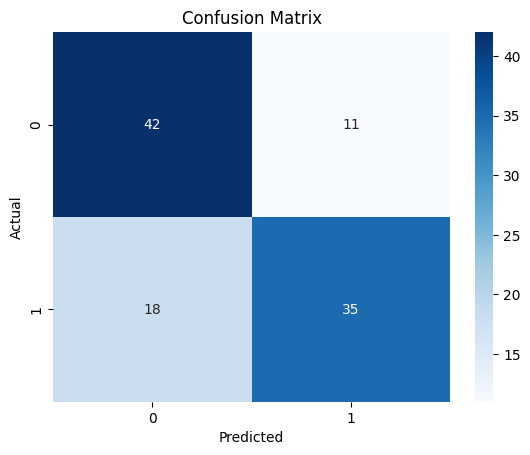

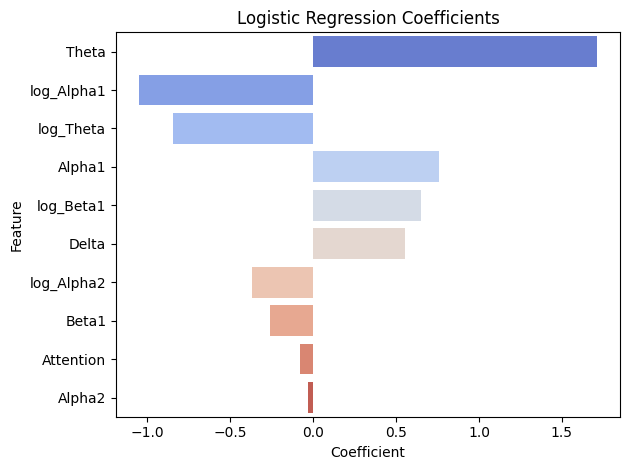


Accuracy: 0.7264

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.79      0.74        53
         1.0       0.76      0.66      0.71        53

    accuracy                           0.73       106
   macro avg       0.73      0.73      0.73       106
weighted avg       0.73      0.73      0.73       106

ROC-AUC Score: 0.8053


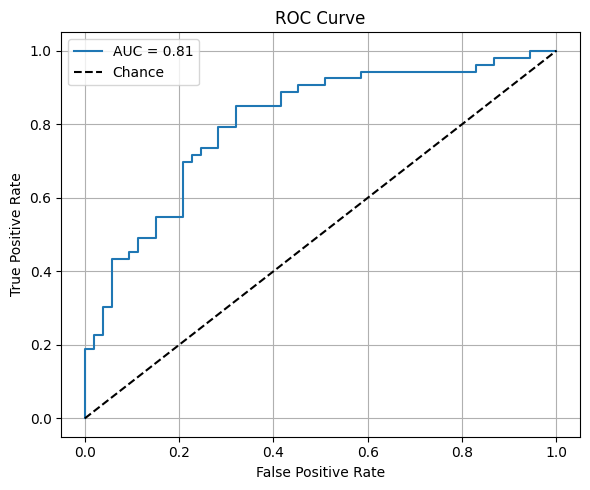

In [53]:
# ========== Feature Engineering ==========
def add_band_power_ratios(df):
    df = df.copy()
    df['theta_alpha_ratio'] = df['Theta'] / (df['Alpha1'] + df['Alpha2'] + 1e-9)
    df['beta_alpha_ratio'] = (df['Beta1'] + df['Beta2']) / (df['Alpha1'] + df['Alpha2'] + 1e-9)
    df['engagement_index'] = (df['Beta1'] + df['Beta2']) / (df['Alpha1'] + df['Theta'] + 1e-9)
    df['AlphaBeta1Ratio'] = df['Alpha1'] / (df['Beta1'] + 1e-6)
    return df

def log_transform_skewed(df, cols=None):
    df = df.copy()
    if cols is None:
        cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    for col in cols:
        if (df[col] > 0).all():
            df[f'log_{col}'] = np.log1p(df[col])
    return df

def run_anova_test(df, numerical_cols, label_col):
    results = []
    for col in numerical_cols:
        groups = [group[col].dropna() for _, group in df.groupby(label_col)]
        try:
            f_val, p_val = stats.f_oneway(*groups)
            results.append({'feature': col, 'f_value': f_val, 'p_value': p_val})
        except:
            continue
    return pd.DataFrame(results).sort_values('p_value')

# ========== Main Pipeline ==========

def full_pipeline(df):
    # Extract target and drop label-related columns
    df = df.copy()
    y = df['user-definedlabeln']
    X = df.drop(['user-definedlabeln', 'time_bin'], axis=1, errors='ignore')

    # Add engineered features
    X = add_band_power_ratios(X)
    X = log_transform_skewed(X)

    # Combine X and y back for ANOVA
    X['label'] = y

    # ANOVA for top features
    num_cols = [col for col in X.columns if X[col].dtype in ['float64', 'int64'] and col != 'label']
    anova_results = run_anova_test(X, num_cols, 'label')
    print("Top ANOVA features:\n", anova_results.head())
    
    # Choose top 10 lowest p values from ANOVA test as features for training
    top_features = anova_results.head(10)['feature'].tolist()

    # Final feature and target split
    y = X['label']
    X = X[top_features]

    # Check class balance
    class_counts = y.value_counts()
    print("\nClass distribution:\n", class_counts)
    apply_smote = class_counts.min() / class_counts.max() < 0.5
    if apply_smote:
        print("SMOTE will be applied due to imbalance.")
    else:
        print("No SMOTE needed.")

    # Train-test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE if class imbalanced
    if apply_smote:
        smote = SMOTE(random_state=42)
        X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

    # Train and evaluate
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Coefficient plot (for logistic regression)
    coef_df = pd.DataFrame({
        'Feature': top_features,
        'Coefficient': model.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
    plt.title("Logistic Regression Coefficients")
    plt.tight_layout()
    plt.show()

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

    print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", round(roc_auc_score(y_test, y_pred_prob), 4))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_prob):.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, coef_df, anova_results

# === Run the pipeline ===
model, coef_df, anova_results = full_pipeline(bin_avg_df)

# LSTM: Data Preparation

In [54]:
roll_avg_df.head()

user-definedlabeln       Raw     Delta     Theta    Alpha1    Alpha2  \
0                 0.0  0.475836  0.220222  0.149517  0.192145  0.159742   
1                 0.0  0.223110  0.392546  0.287994  0.193694  0.109661   
2                 0.0  0.230625  0.469374  0.360387  0.290767  0.205738   
3                 0.0  0.206647  0.615707  0.346471  0.294356  0.169241   
4                 0.0  0.200083  0.555020  0.345908  0.247291  0.183331   

      Beta1     Beta2    Gamma1    Gamma2  Attention  Mediation  
0  0.224839  0.177775  0.125374  0.066032   0.630061   0.545950  
1  0.154370  0.123703  0.125857  0.125342   0.457293   0.641253  
2  0.177476  0.171151  0.145974  0.144931   0.455352   0.656414  
3  0.184816  0.179098  0.160706  0.151907   0.442249   0.674609  
4  0.169227  0.177640  0.145395  0.152752   0.445923   0.669843

In [55]:
# Group by label to prevent mixed sequences across different target labels
train_groups = []
val_groups = []

# Percent of data for train data
fraction_train = 0.7 

for label, group in roll_avg_df.groupby('user-definedlabeln'):
    split_point = round(len(group) * fraction_train)
    train = group.iloc[:split_point]  
    val = group.iloc[split_point:]   
    train_groups.append(train)
    val_groups.append(val)

train_df = pd.concat(train_groups)
val_df = pd.concat(val_groups)

In [56]:
# Sequence parameters
seq_length = 10 # Time steps to form one input sample
ph = 5 # Num steps to predict ahead

# Create nested list for train data,
# With sequence of measurements as input and the measurement at your predictive horizon as expected output
seq_arrays = []
seq_labs = []

# Create list of sequence length labels
for start in range(0,len(train_df)-seq_length-ph):
    # Extract brainwave feature seq
    seq = train_df[brainwave_cols].iloc[start : start + seq_length].to_numpy()
    # Extract label at predictive horizon
    label = train_df['user-definedlabeln'].iloc[start + seq_length + ph]

    seq_arrays.append(seq)
    seq_labs.append(label)

# Convert lists to numpy arrays with correct dtype
seq_arrays = np.array(seq_arrays).astype(np.float32)
seq_labs = np.array(seq_labs).astype(np.float32)

# LSTM: Check shape, lengths, sample overlap, class distribution

In [57]:
print("Validation set length:", len(val_df))
print("Max sequences possible:", max(0, len(val_df) - seq_length - ph))

Validation set length: 769
Max sequences possible: 754


In [58]:
print(len(train_df), seq_length, ph)
print(len(train_df) - seq_length - ph)

1794 10 5
1779


In [59]:
print(f"train_df length: {len(train_df)}")
print(f"Number of sequences created: {len(seq_arrays)}")
print(f"Shape of seq_arrays: {seq_arrays.shape}")
print(f"Shape of seq_labs: {seq_labs.shape}")

train_df length: 1794
Number of sequences created: 1779
Shape of seq_arrays: (1779, 10, 11)
Shape of seq_labs: (1779,)


In [60]:
# Check to make sure shapes match
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length,len(brainwave_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [61]:
# Confirm no samples overlap between train and val df before index reset
overlap = set(train_df.index).intersection(set(val_df.index))
print("Overlap samples:", overlap)

Overlap samples: set()


In [62]:
# Reset index after confirming no overlap in samples between train and val set
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [63]:
print('training set target value count:\n', + train_df['user-definedlabeln'].value_counts())
print('validation set target value count:\n', + val_df['user-definedlabeln'].value_counts())

training set target value count:
 user-definedlabeln
1.0    920
0.0    874
Name: count, dtype: int64
validation set target value count:
 user-definedlabeln
1.0    394
0.0    375
Name: count, dtype: int64


# LSTM: Build and fit the network

In [64]:
# Path to save model
model_path = './LSTM_models/LSTM_model1.keras'

# Build the network
nb_features = len(brainwave_cols) #number of features included in the training data
nb_out = 1 # Expected output length
model = Sequential()

# Add first LSTM layer ( units = Number of hidden units)
model.add(Input(shape=(seq_length, nb_features)))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2)) # Dropout for regularization

# Add second LSTM layer
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Dense output layer with sigmoid activation for binary output
model.add(Dense(units=nb_out))
model.add(Activation("sigmoid"))
        
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [65]:
# Fit the network
history = model.fit(
    seq_arrays,
    seq_labs,
    epochs=60,
    batch_size=32,
    validation_split=0.05,
    verbose=1,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)]
)

# List all data in history
print(history.history.keys())

Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6268 - loss: 0.6589 - val_accuracy: 0.3146 - val_loss: 0.9972
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7362 - loss: 0.5051 - val_accuracy: 0.1236 - val_loss: 1.4788
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7548 - loss: 0.4859 - val_accuracy: 0.4045 - val_loss: 1.1820
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7652 - loss: 0.4723 - val_accuracy: 0.3820 - val_loss: 1.4457
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7672 - loss: 0.4824 - val_accuracy: 0.3933 - val_loss: 1.3996
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7813 - loss: 0.4555 - val_accuracy: 0.3146 - val_loss: 1.6189
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7627 - loss: 0.4365 - val_accuracy: 0.3596 - val_loss: 1.3824
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7757 - loss: 0.4191 - val_accuracy: 0.2135 - v

# LSTM: Visualize accuracy and loss for binary classification performance

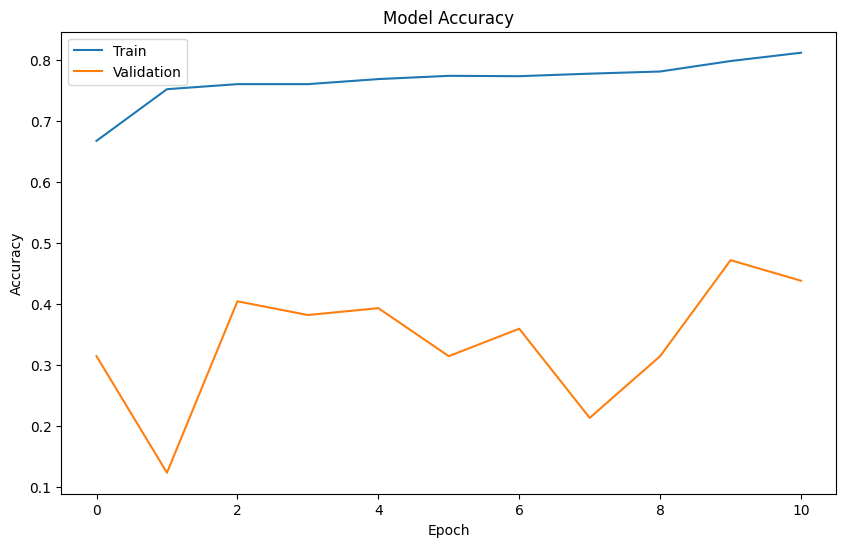

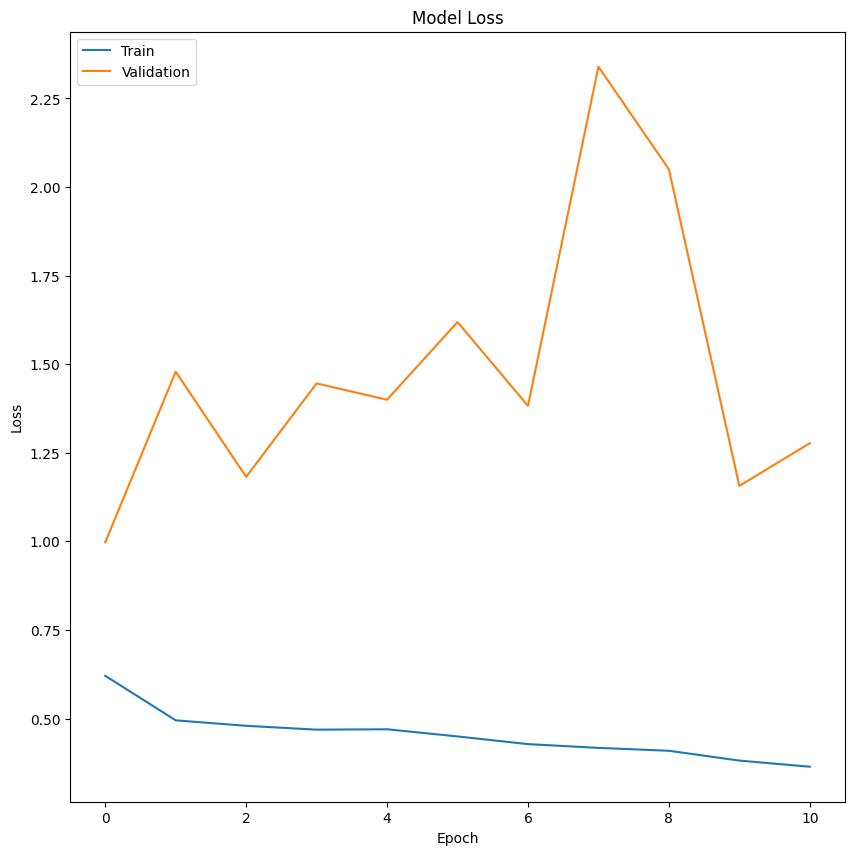

In [66]:
# Plot train and val accuracy values
fig_acc = plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot train and val loss values
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# LSTM Validation

In [67]:
# Create nested list structure for validation data
val_arrays = []
val_labs = []
#create list of GAP readings starting with a minimum of two readings
for end in range(2, len(val_df)-ph):
#add short sequences until we reach the sequence length
    if end < seq_length:
        # Shorter seq from start to end
        seq = val_df[brainwave_cols].iloc[0:end].to_numpy()
    else:
        # Fixed-length seq to end
        seq = val_df[brainwave_cols].iloc[end - seq_length:end].to_numpy()

    label_index = end + ph
    if label_index < len(val_df):
        val_arrays.append(seq)
        val_labs.append(val_df['user-definedlabeln'].iloc[label_index])
    else:
        break

# Pad seq to seq_length (pad shorter seq with zeroes at start)
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32, padding='pre')

# Convert labels to numpy float32
val_labs = np.array(val_labs).astype(np.float32)

24/24 - 0s - 10ms/step - accuracy: 0.6601 - loss: 1.1324

Loss: 1.1324
Accuracy: 0.6601
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


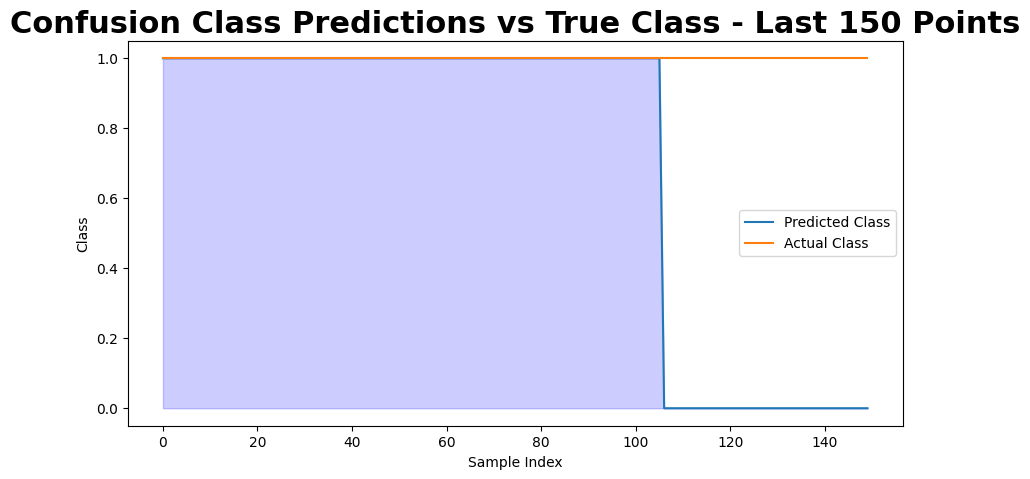

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.58      0.62       368
           1       0.65      0.74      0.69       394

    accuracy                           0.66       762
   macro avg       0.66      0.66      0.66       762
weighted avg       0.66      0.66      0.66       762



In [68]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)

print('\nLoss: {:.4f}'.format(scores_test[0]))
print('Accuracy: {:.4f}'.format(scores_test[1]))


y_pred_prob = model.predict(val_arrays)
y_pred_test = (y_pred_prob > 0.5).astype(int).flatten()
y_true_test = val_labs.astype(int)

test_set = pd.DataFrame({'Predicted': y_pred_test, 'Actual': y_true_test})


# Plot the predicted data vs. the actual data
# Limit plot to num values
plot_values = 150
x = range(len(y_pred_test[-plot_values:]))

plt.figure(figsize=(10, 5))
plt.plot(x,y_pred_test[-plot_values:], label = 'Predicted Class')
plt.fill_between(x, 0, y_pred_test[-plot_values:], color='blue', alpha=0.2)  # Color fill under predicted line
plt.plot(y_true_test[-plot_values:], label = 'Actual Class')

plt.title(f'Confusion Class Predictions vs True Class - Last {plot_values} Points', fontsize=22, fontweight='bold')
plt.ylabel('Class')
plt.xlabel('Sample Index')
plt.legend()
plt.show()

print("Classification Report:\n", classification_report(y_true_test, y_pred_test))

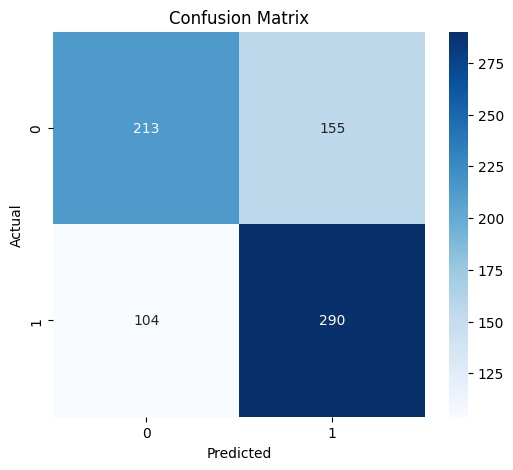

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


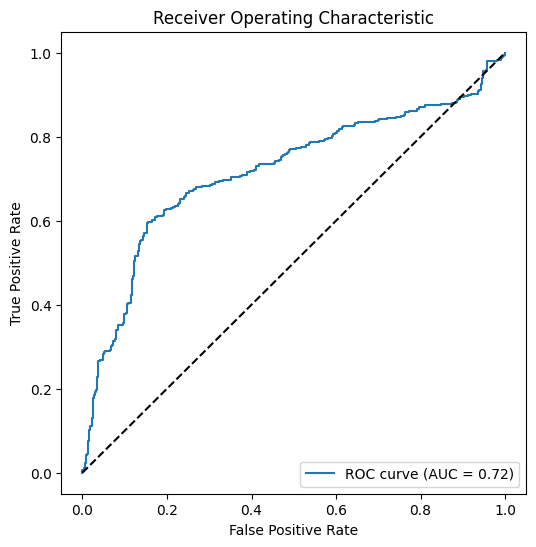

In [70]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(val_arrays).flatten()
fpr, tpr, thresholds = roc_curve(y_true_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

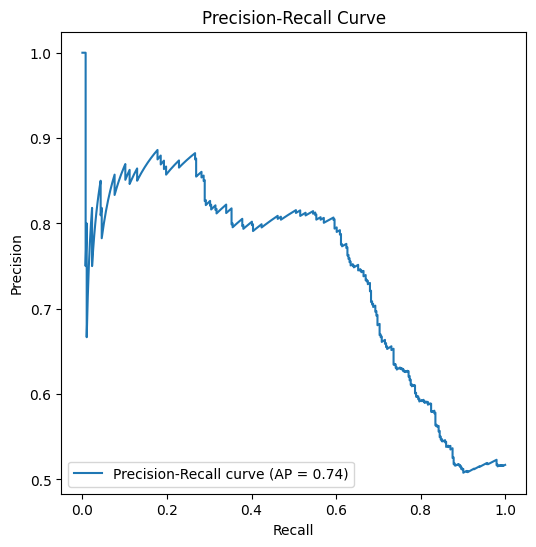

In [71]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true_test, y_pred_prob)
avg_precision = average_precision_score(y_true_test, y_pred_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [72]:
from sklearn.metrics import f1_score

# Convert probabilities to binary predictions at threshold 0.5
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Compute F1 score
f1 = f1_score(y_true_test, y_pred_binary)
print(f"F1 Score (threshold = 0.5): {f1:.2f}")

F1 Score (threshold = 0.5): 0.69


In [73]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_true_test, y_pred_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)  # avoid divide-by-zero
best_idx = f1_scores.argmax()
best_thresh = thresh[best_idx]

print(f"Best F1 Score: {f1_scores[best_idx]:.2f} at threshold {best_thresh:.2f}")

Best F1 Score: 0.70 at threshold 0.80


For prediction confidence threshold = 0.5 (a common default), the model predicts positive only if the predicted probability is 0.5 or higher.

For best threshold value, a predicted probability of this threshold or higher is considered positive.